# TP4, INF8225 2025

**Sources**

* Dataset: [UTKFace](https://susanqq.github.io/UTKFace/)

# Imports and data initializations

## Imports

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install torchinfo > /dev/null
!pip install einops > /dev/null
!pip install wandb > /dev/null
!pip install opendatasets > /dev/null


In [ ]:
from itertools import takewhile
from collections import Counter, defaultdict

import numpy as np
from sklearn.model_selection import train_test_split
import pandas as pd

import torch
# cpal
print(torch.__version__)

import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence
from torchvision import transforms as T

import einops
import wandb
from torchinfo import summary

import os
import opendatasets as od

import multiprocessing as mp

# plotting
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px

from PIL import Image
import os

import sympy

import copy

import timm

import pprint

import gc

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


2.6.0+cu124


In [ ]:
CHECKPOINT_DIR = '/content/drive/MyDrive/INF8225_TP4_ckpt'
os.makedirs(CHECKPOINT_DIR, exist_ok=True)

## Dataset analysis

In [ ]:
# Our dataset
dataset = 'https://www.kaggle.com/datasets/nipunarora8/age-gender-and-ethnicity-face-data-csv/'
od.download(dataset)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: clovisjohn
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/nipunarora8/age-gender-and-ethnicity-face-data-csv


In [ ]:
dataset = 'https://www.kaggle.com/datasets/jangedoo/utkface-new/data'
od.download(dataset)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: clovisjohn
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/jangedoo/utkface-new


In [ ]:
df = pd.read_csv('./age-gender-and-ethnicity-face-data-csv/age_gender.csv')
df.head()

,age,ethnicity,gender,img_name,pixels
0,1,2,0,20161219203650636.jpg.chip.jpg,129 128 128 126 127 130 133 135 139 142 145 14...
1,1,2,0,20161219222752047.jpg.chip.jpg,164 74 111 168 169 171 175 182 184 188 193 199...
2,1,2,0,20161219222832191.jpg.chip.jpg,67 70 71 70 69 67 70 79 90 103 116 132 145 155...
3,1,2,0,20161220144911423.jpg.chip.jpg,193 197 198 200 199 200 202 203 204 205 208 21...
4,1,2,0,20161220144914327.jpg.chip.jpg,202 205 209 210 209 209 210 211 212 214 218 21...


.

**nipunarora8/age-gender-and-ethnicity-face-data-csv has images scaled down to 48x48 so we load original 200x200 images from jangedoo/utkface-new/data**

**We could decide to use directly jangedoo/utkface-new/data and parse features from file names bold text**

.

In [ ]:

folder = './utkface-new/UTKFace'
for filename in os.listdir(folder):
    old_filepath = os.path.join(folder, filename)

    # Ensure that the item is a file.
    if os.path.isfile(old_filepath):
        parts = filename.split('_', maxsplit=3)

        if len(parts) == 4:
            new_filename = parts[3]
            new_filepath = os.path.join(folder, new_filename)

            os.rename(old_filepath, new_filepath)

In [ ]:
original_images_dir = './utkface-new/UTKFace'

def load_original_image(img_name):
    image_path = os.path.join(original_images_dir, img_name)
    try:
        img = Image.open(image_path).convert('L')
        return np.array(img, dtype='float32')
    except Exception as e:
        print(f"Error loading {image_path}: {e}")
        return None

df['pixels'] = df['img_name'].apply(load_original_image)

df.head()


,age,ethnicity,gender,img_name,pixels
0,1,2,0,20161219203650636.jpg.chip.jpg,"[[129.0, 129.0, 129.0, 128.0, 128.0, 127.0, 12..."
1,1,2,0,20161219222752047.jpg.chip.jpg,"[[189.0, 173.0, 150.0, 124.0, 99.0, 79.0, 72.0..."
2,1,2,0,20161219222832191.jpg.chip.jpg,"[[69.0, 68.0, 67.0, 66.0, 67.0, 69.0, 72.0, 74..."
3,1,2,0,20161220144911423.jpg.chip.jpg,"[[193.0, 193.0, 194.0, 195.0, 195.0, 196.0, 19..."
4,1,2,0,20161220144914327.jpg.chip.jpg,"[[201.0, 201.0, 202.0, 203.0, 203.0, 204.0, 20..."


In [ ]:
print(df["pixels"][0].shape)

(200, 200)


In [ ]:
df.shape

(23705, 5)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23705 entries, 0 to 23704
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        23705 non-null  int64 
 1   ethnicity  23705 non-null  int64 
 2   gender     23705 non-null  int64 
 3   img_name   23705 non-null  object
 4   pixels     23705 non-null  object
dtypes: int64(3), object(2)
memory usage: 926.1+ KB


In [ ]:
afig = px.histogram(df, x="age")
fig.update_layout(title_text='Age Histogram')
fig.show()

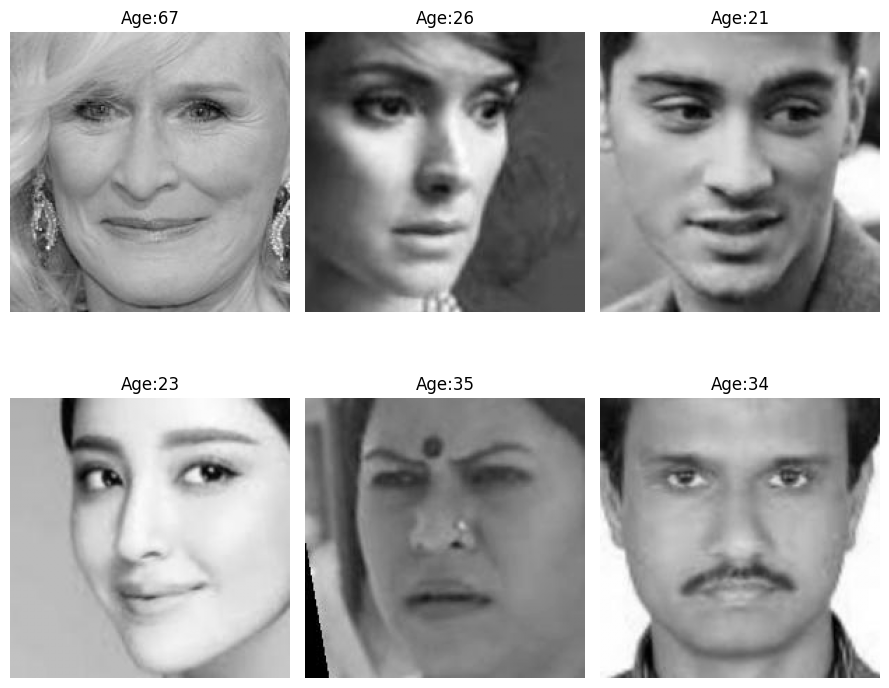

In [ ]:
rows = 2
cols = 3
figure = plt.figure(figsize=(cols*3,rows*4))
for i in range(1, cols*rows + 1):
    k = np.random.randint(0,len(df))
    figure.add_subplot(rows, cols, i)

    age = df.age[k]

    im = df.pixels[k]
    plt.imshow(im, cmap='gray')
    plt.axis('off')
    plt.title(f'Age:{age}')

plt.tight_layout()
plt.show()

## Dataset Preprocessing

In [ ]:
# Normalization
# df['pixels'] = df['pixels'].apply(lambda x: x/255)

In [ ]:
class UTKFaceDataset(Dataset):
    def __init__(self, df, num_classes, transform=None, label_mode: str = 'class'):
        super().__init__()
        self.df = df
        self.num_classes = num_classes
        self.transform = transform
        self.label_mode = label_mode

    def __len__(self):
        return len(self.df)

    def __getitem__(self,i):
        row = self.df.iloc[i]
        age = row['age']
        img_np = row['pixels']

        if img_np.dtype != np.uint8:
            img_np = img_np.astype(np.uint8)
        img = Image.fromarray(img_np, mode='L')

        if self.transform is not None:
            img = self.transform(img)
        else:
            img = torch.as_tensor(img_np, dtype=torch.float32)[None] / 255.

        if self.label_mode == 'class':
          class_idx = int((age - 1) / (90 / self.num_classes))
          class_idx = min(class_idx, self.num_classes - 1)
          label  = torch.tensor(class_idx, dtype=torch.long)
        else:
          label = torch.tensor(float(age), dtype=torch.float32)

        return img, label

# Based on https://github.com/Ebimsv/Facial_Age_estimation_PyTorch/blob/main/custom_dataset_dataloader.py
# --------------------------- TRANSFORMS -------------------------------------
# Training pipeline
train_transform = T.Compose([
    T.RandomResizedCrop(224, scale=(0.80, 1.0)),
    T.RandomHorizontalFlip(p=0.5),
    T.RandomRotation(degrees=15, fill=0),               # mild pose variation
    T.ToTensor(),                                       # uint8 → float, 0‑1
    T.Normalize(mean=[0.5], std=[0.5])                  # 0‑1 → (‑1, 1)
])

# Validation / test pipeline (deterministic)
eval_transform = T.Compose([
    T.Resize(256),
    T.CenterCrop(224),
    T.ToTensor(),
    T.Normalize(mean=[0.5], std=[0.5])
])

# def preprocess(
#     df: pd.DataFrame,
#     min_age: int = 0,
#     max_age: int = 90
# )
#     """Preprocess the dataset.
#     Remove rows where age < min_age or > max_age
#     """
#     filtered = df[(df['age'] >= min_age) & (df['age'] <= max_age)].reset_index(drop=True)
#     return filtered


def build_datasets(
      df: pd.DataFrame,
      min_age: int = 1,
      max_age: int = 90,
      num_classes = 30,
      label_mode='class'
    ) -> tuple:
    """Build the training, validation and testing datasets.
    Remove rows where age < min_age or > max_age

    Args
    ----

    Output
    ------
        - (train_dataset, val_dataset): Tuple of the two UTKFaceDataset objects.
    """
    filtered = df[(df['age'] >= min_age) & (df['age'] <= max_age)].reset_index(drop=True)
    train, test = train_test_split(filtered, test_size=0.1, random_state=0)
    train = UTKFaceDataset(train,num_classes, transform=train_transform,label_mode=label_mode)
    test = UTKFaceDataset(test,num_classes,transform=eval_transform,label_mode=label_mode)

    return train, test


# Models architecture
This is where you have to code the architectures.



## CNN models


### CNN 1


In [ ]:
# Basic CNN to test full notebook. Source : https://www.datacamp.com/tutorial/pytorch-cnn-tutorial

import torch
import torch.nn as nn
import torch.nn.functional as F

class CNN1(nn.Module):
    def __init__(self, in_channels, dim_hidden=256, dropout=0.1):
        """
        Convolutional Neural Network for real-valued age prediction.

        Parameters
        ----------
        in_channels : int
            Number of input image channels (e.g., 1 for grayscale images).
        dim_hidden : int
            Number of neurons in the fully connected layer.
        dropout : float
            Dropout rate to use before the final regression layer.
        """
        super(CNN1, self).__init__()

        # First convolutional layer
        self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=8, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)  # Downsampling: 200x200 → 100x100

        # Second convolutional layer
        self.conv2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, padding=1)
        # Downsampling again: 100x100 → 50x50

        # Dropout layer
        self.dropout = nn.Dropout(dropout)

        # Fully connected layer to produce real-valued age prediction
        self.fc1 = nn.Linear(16 * 50 * 50, dim_hidden)
        self.fc2 = nn.Linear(dim_hidden, 1)  # Output layer

    def forward(self, x):
        """
        Forward pass of the model.

        Parameters
        ----------
        x : torch.Tensor
            Batch of input images with shape (batch_size, in_channels, H, W)

        Returns
        -------
        torch.Tensor
            Predicted age for each image in the batch, shape (batch_size, 1)
        """
        x = F.relu(self.conv1(x))  # Convolution 1 + ReLU activation
        x = self.pool(x)           # Pooling 1
        x = F.relu(self.conv2(x))  # Convolution 2 + ReLU activation
        x = self.pool(x)           # Pooling 2

        x = x.view(x.size(0), -1)  # Flatten the tensor
        x = F.relu(self.fc1(x))    # Fully connected + ReLU
        x = self.dropout(x)        # Apply dropout
        x = self.fc2(x)            # Final output: predicted age
        return x.squeeze(1)  # Optionally remove final dimension for regression


### CNN 2


In [ ]:
class CNN2(nn.Module) :
    def __init__(self,
                 age_classes: int,
                 hidden_dim: int,
                 dropout: float
                 ) :
        super(CNN2, self).__init__()
        '''
        '''
        self.cnnModel = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size = 3, stride = 1, padding = 1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
            nn.Dropout2d(dropout),
            nn.MaxPool2d(kernel_size = 2, stride = 2, padding = 1),

            nn.Conv2d(64, 128, kernel_size = 3, stride = 1, padding = 1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2, padding = 1),

            nn.Conv2d(128, 256, kernel_size = 3, stride = 1, padding = 1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2, padding = 1),

            #nn.LeakyReLU(),
            nn.AdaptiveAvgPool2d((1,1)) #flatten
        )

        self.dnnModel = nn.Sequential(
            nn.Linear(256, hidden_dim),
            nn.LeakyReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, 32),
            nn.LeakyReLU(),
            nn.Dropout(dropout),
        )

        self.age_classifier = nn.Linear(32, age_classes)
    def forward(self, x) :
        '''
        output = self.model.forward_features(x)
        age = self.age_classifier(output)
        '''
        output = self.cnnModel(x)
        output = output.view(output.size(0), -1)
        output = self.dnnModel(output)

        age = self.age_classifier(output)
        #print(age.shape)
        return age

# Training loop
This is a basic training loop code. It takes a big configuration dictionnary to avoid never ending arguments in the functions.
We use [Weights and Biases](https://wandb.ai/) to log the trainings.
It logs every training informations and model performances in the cloud.
You have to create an account to use it. Every accounts are free for individuals or research teams.

In [ ]:
def print_logs(dataset_type: str, logs: dict):
    """Print the logs.

    Args
    ----
        dataset_type: Either "Train", "Eval", "Test" type.
        logs: Containing the metric's name and value.
    """
    desc = [
        f'{name}: {value:.2f}'
        for name, value in logs.items()
    ]
    desc = '\t'.join(desc)
    desc = f'{dataset_type} -\t' + desc
    desc = desc.expandtabs(5)
    print(desc)


def loss_batch(
        model: nn.Module,
        images,#: torch.LongTensor,
        labels,#: torch.LongTensor,
        config: dict,
        classification: bool = True
    )-> dict:
    """Compute the metrics associated with this batch.
    The metrics are:
        - loss

    Args
    ----

    ------
        metrics: Dictionnary containing evaluated metrics on this batch.
    """
    device = config['device']
    loss_fn = config['loss'].to(device)
    metrics = dict()

    images, labels = images.to(device), labels.to(device)

    # Loss
    pred = model(images)

    if not classification and labels.dim() == 1:
        labels = labels.unsqueeze(1)


    metrics['loss'] = loss_fn(pred, labels)

    return metrics


def eval_model(model: nn.Module, dataloader: DataLoader, config: dict,classification) -> dict:
    """Evaluate the model on the given dataloader.
    """
    device = config['device']
    logs = defaultdict(list)

    model.to(device)
    model.eval()

    with torch.no_grad():
        for source, target in dataloader:
            metrics = loss_batch(model, source, target, config,classification)
            for name, value in metrics.items():
                logs[name].append(value.cpu().item())

    for name, values in logs.items():
        logs[name] = np.mean(values)
    return logs

def idx_to_range(idx: int, bin_w: float) -> str:
    lower = 1 + idx * bin_w
    upper = lower + bin_w - 1
    return f"{int(lower)}–{int(upper)}"


def train_model(model: nn.Module, config: dict,classification=True):
    """Train the model.
    """
    train_loader, val_loader = config['train_loader'], config['val_loader']
    train_dataset, val_dataset = train_loader.dataset, val_loader.dataset
    optimizer = config['optimizer']
    clip = config['clip']
    device = config['device']

    patience = config.get('early_stop_patience', 6)
    min_delta = config.get('early_stop_delta', 0.0)
    best_val_loss = float('inf')
    epochs_no_improve = 0

    columns = ['epoch']
    for mode in ['train', 'validation']:
        columns += [
            f'{mode} - {colname}'
            for colname in ['source', 'target', 'predicted', 'likelihood']
        ]
    log_table = wandb.Table(columns=columns)


    print(f'Starting training for {config["epochs"]} epochs, using {device}.')
    for e in range(config['epochs']):
        print(f'\nEpoch {e+1}')

        model.to(device)
        model.train()
        logs = defaultdict(list)

        for batch_id, (source, target) in enumerate(train_loader):
            optimizer.zero_grad()

            metrics = loss_batch(model, source, target, config,classification)
            loss = metrics['loss']

            loss.backward()
            if batch_id == 0 and clip==0:                      # first batch each epoch
                total_norm = torch.nn.utils.clip_grad_norm_(model.parameters(),
                                                            max_norm=float('inf'))
                wandb.log({'grad_norm': total_norm})
                print({'grad_norm': total_norm})

            if batch_id == 0:                      # first batch each epoch
                total_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
                wandb.log({'grad_norm': total_norm})
                print({'grad_norm': total_norm})

            optimizer.step()

            for name, value in metrics.items():
                logs[name].append(value.cpu().item())  # Don't forget the '.item' to free the cuda memory

            if batch_id % config['log_every'] == 0:
                for name, value in logs.items():
                    logs[name] = np.mean(value)

                train_logs = {
                    f'Train - {m}': v
                    for m, v in logs.items()
                }
                wandb.log(train_logs)
                logs = defaultdict(list)

        # Logs
        if len(logs) != 0:
            for name, value in logs.items():
                logs[name] = np.mean(value)
            train_logs = {
                f'Train - {m}': v
                for m, v in logs.items()
            }
        else:
            logs = {
                m.split(' - ')[1]: v
                for m, v in train_logs.items()
            }

        print_logs('Train', logs)

        logs = eval_model(model, val_loader, config,classification)
        print_logs('Eval', logs)
        val_logs = {
            f'Validation - {m}': v
            for m, v in logs.items()
        }

        current_val_loss = logs['loss']

        if 'scheduler' in config and isinstance(config['scheduler'], torch.optim.lr_scheduler.ReduceLROnPlateau):
            config['scheduler'].step(current_val_loss)
        elif 'scheduler' in config and config['scheduler'] is not None \
              and not isinstance(config['scheduler'], torch.optim.lr_scheduler.ReduceLROnPlateau):
              config['scheduler'].step()

        # -------------------- EARLY STOP logic -----------------------
        improvement = best_val_loss - current_val_loss
        if improvement > min_delta:
            best_val_loss = current_val_loss
            epochs_no_improve = 0

        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print(f"\nEarly stopping triggered after epoch {e+1} "
                      f"(no improvement in validation loss for {patience} epochs).")
                break
        # -------------------------------------------------------------


        logs = {**train_logs, **val_logs}  # Merge dictionnaries
        wandb.log(logs)  # Upload to the WandB cloud


        model.eval()

        # Prediction for a random train sample
        train_idx = torch.randint(len(train_dataset), (1,)).item()
        train_image, train_label = train_dataset[train_idx]
        train_image_device = train_image.unsqueeze(0).to(device)  # add batch dimension

        with torch.no_grad():
            train_pred = model(train_image_device)


        # Prediction for a random validation sample
        val_idx = torch.randint(len(val_dataset), (1,)).item()
        val_image, val_label = val_dataset[val_idx]
        val_image_device = val_image.unsqueeze(0).to(device)  # add batch dimension

        with torch.no_grad():
            val_pred = model(val_image_device)




        if classification:
            train_pred_class = torch.argmax(train_pred, dim=1).item()
            train_likelihood = torch.softmax(train_pred, dim=1)[0][train_pred_class].item()

            val_pred_class = torch.argmax(val_pred, dim=1).item()
            val_likelihood = torch.softmax(val_pred, dim=1)[0][val_pred_class].item()


            # Convert class indices to ranges
            bin_width = 90 / config['num_classes']
            train_label_age = idx_to_range(train_label.item(), bin_width)
            train_pred_age  = idx_to_range(train_pred_class,  bin_width)
            val_label_age   = idx_to_range(val_label.item(),   bin_width)
            val_pred_age    = idx_to_range(val_pred_class,    bin_width)
        else:
            train_pred_age = float(train_pred.squeeze().item())
            val_pred_age   = float(val_pred.squeeze().item())
            train_label_age = float(train_label)
            val_label_age   = float(val_label)
            train_likelihood = val_likelihood = 1.0       # dummy value
            train_pred_class = val_pred_class = 0         # placeholder for table


        # Print one prediction for the epoch for both train and validation, with ages converted from class indices.
        print(f'Epoch {e+1} Train Prediction - Real age: {train_label_age}, Predicted: {train_pred_age}, Likelihood: {train_likelihood:.4f}')
        print(f'Epoch {e+1} Val Prediction   - Real age: {val_label_age}, Predicted: {val_pred_age}, Likelihood: {val_likelihood:.4f}')
        # # Log predictions to wandb table
        row_data = [
            e + 1,
            wandb.Image(train_image.squeeze(0).cpu().numpy()),  # train - source: image
            train_label_age,                                      # train - target: true age (converted from class)
            train_pred_age,                                       # train - predicted: predicted age (converted from class)
            train_likelihood,                                     # train - likelihood: probability score
            wandb.Image(val_image.squeeze(0).cpu().numpy()),      # validation - source: image
            val_label_age,                                        # validation - target: true age (converted from class)
            val_pred_age,                                         # validation - predicted: predicted age (converted from class)
            val_likelihood                                        # validation - likelihood: probability score
        ]
        log_table.add_data(*row_data)

    # Log the table at the end of the training
    wandb.log({'Model predictions': log_table})

# Training the models
We can now finally train the models.
Choose the right hyperparameters, play with them and try to find
ones that lead to good models and good training curves.
Try to reach a loss under 1.0.

---

You usually don't want to log anything onto WandB when testing your implementation.
To deactivate WandB without having to change any line of code, you can type `!wandb offline` in a cell.

Once you have rightly implemented the models, you can train bigger models on bigger datasets.
When you do this, do not forget to change the runtime as GPU (and use `!wandb online`)!

## INIT

In [ ]:
# Checking GPU and logging to wandb

!wandb login
!wandb online


wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: ybjc (ybjc-polytechnique-montr-al) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
W&B online. Running your script from this directory will now sync to the cloud.


In [ ]:
!nvidia-smi

Sat Apr 26 17:09:55 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off |   00000000:00:04.0 Off |                    0 |
| N/A   30C    P0             43W /  400W |       5MiB /  40960MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [ ]:
print("os.cpu_count()          :", os.cpu_count())
print("multiprocessing count   :", mp.cpu_count())
print("torch.get_num_threads() :", torch.get_num_threads())

os.cpu_count()          : 12
multiprocessing count   : 12
torch.get_num_threads() : 6


## CNN2

In [ ]:
1# Instanciate the datasets

train_dataset, val_dataset = build_datasets(
  df,
  min_age = 1,
  max_age = 90
)


print(f'\nTraining examples: {len(train_dataset):,}')
print(f'Validation examples: {len(val_dataset):,}')


Training examples: 21,256
Validation examples: 2,362


In [ ]:
# Build the model, the dataloaders, optimizer and the loss function
# Log every hyperparameters and arguments into the config dictionnary

config = {
    # General parameters
    'epochs': 50,
    'batch_size': 128,
    'lr': 1e-3,
    'clip': 5,
    'device': 'cuda' if torch.cuda.is_available() else 'cpu',

    # Model parameters
    'dim_hidden': 256, # will be used for nn at the end of cnn
    'dropout': 0.1,
    'model_type': 'CNN2',

    # Others
    'seed': 0,
    'log_every': 50,  # Number of batches between each wandb logs

    'num_classes': 30
}

torch.manual_seed(config['seed'])

config['train_loader'] = DataLoader(
    train_dataset,
    batch_size=config['batch_size'],
    shuffle=True,
    num_workers=8 if os.cpu_count() >=12 else 2
    #collate_fn=lambda batch: generate_batch(batch, config['src_pad_idx'], config['tgt_pad_idx'])
)

config['val_loader'] = DataLoader(
    val_dataset,
    batch_size=config['batch_size'],
    shuffle=False,
    num_workers=4 if os.cpu_count() >=12 else 2
    #collate_fn=lambda batch: generate_batch(batch, config['src_pad_idx'], config['tgt_pad_idx'])
)



#model = CNN1(1, config['range_max'])
model = CNN2(config['num_classes'], config['dim_hidden'],config['dropout'])

config['optimizer'] = optim.Adam(
    model.parameters(),
    lr=config['lr'],
)

config['loss'] = nn.CrossEntropyLoss()

summary(
    model
)

Layer (type:depth-idx)                   Param #
CNN2                                     --
├─Sequential: 1-1                        --
│    └─Conv2d: 2-1                       640
│    └─BatchNorm2d: 2-2                  128
│    └─LeakyReLU: 2-3                    --
│    └─Dropout2d: 2-4                    --
│    └─MaxPool2d: 2-5                    --
│    └─Conv2d: 2-6                       73,856
│    └─BatchNorm2d: 2-7                  256
│    └─LeakyReLU: 2-8                    --
│    └─MaxPool2d: 2-9                    --
│    └─Conv2d: 2-10                      295,168
│    └─BatchNorm2d: 2-11                 512
│    └─LeakyReLU: 2-12                   --
│    └─MaxPool2d: 2-13                   --
│    └─AdaptiveAvgPool2d: 2-14           --
├─Sequential: 1-2                        --
│    └─Linear: 2-15                      65,792
│    └─LeakyReLU: 2-16                   --
│    └─Dropout: 2-17                     --
│    └─Linear: 2-18                      8,224
│    └─

In [ ]:
!wandb online  # online / offline / disabled to activate, deactivate or turn off WandB logging



W&B online. Running your script from this directory will now sync to the cloud.


In [ ]:
# config['epochs'] = 5


# with wandb.init(
#         config=config,
#         project='INF8225 - TP4',  # Title of your project
#         group='CNN - small',
#         save_code=True,
#     ):
#     train_model(model, config)

### Grid search

#### LR and Hidden dim

In [ ]:
# config['epochs'] = 1
# config['lr'] = 0.01
# config['dim_hidden'] = 256


# model = CNN2(config['num_classes'], config['dim_hidden'],config['dropout'])

# config['optimizer'] = optim.Adam(
#     model.parameters(),
#     lr=config['lr'],
# )

# with wandb.init(
#         config=config,
#         project='INF8225 - TP4',  # Title of your project
#         group=f"CNN2 - dropout = {config['dropout']} - epochs = {config['epochs']}",
#         name=f"CNN2 lr = {config['lr']} - hidden_dim = {config['dim_hidden']}",
#         save_code=True,
#     ):
#     train_model(model, config)

In [ ]:
# config['epochs'] = 5
# config['dropout'] = 0.1

# lr_list = [0.1, 0.01, 0.001, 0.0005]          # Learning rates to try
# hidden_dims = [128, 256, 512]         # Hidden dimensions to try

# for lr in lr_list:
#     for hd in hidden_dims:
#         config['lr'] = lr
#         config['dim_hidden'] = hd

#         model = CNN2(config['num_classes'], config['dim_hidden'], config['dropout'])

#         # Initialize the optimizer using the current learning rate
#         config['optimizer'] = optim.Adam(model.parameters(), lr=config['lr'])

#         # Log the current configuration and run the training process using wandb
#         with wandb.init(
#             config=config,
#             project='INF8225 - TP4',  # Title of your project
#             group=f"CNN2 - dropout = {config['dropout']} - epochs = {config['epochs']}",
#             name=f"CNN2 lr = {config['lr']} - hidden_dim = {config['dim_hidden']}",
#             save_code=True,
#         ):
#             train_model(model, config)

In [ ]:
config['epochs'] = 5
config['dropout'] = 0.1

lr_list = [0.001, 0.0005]          # Learning rates to try
hidden_dims = [512, 1024]         # Hidden dimensions to try

for lr in lr_list:
    for hd in hidden_dims:
        config['lr'] = lr
        config['dim_hidden'] = hd

        model = CNN2(config['num_classes'], config['dim_hidden'], config['dropout'])

        # Initialize the optimizer using the current learning rate
        config['optimizer'] = optim.Adam(model.parameters(), lr=config['lr'])

        # Log the current configuration and run the training process using wandb
        with wandb.init(
            config=config,
            project='INF8225 - TP4',  # Title of your project
            group=f"CNN2 - dropout = {config['dropout']} - epochs = {config['epochs']}",
            name=f"CNN2 lr = {config['lr']} - hidden_dim = {config['dim_hidden']}",
            save_code=True,
        ):
            train_model(model, config)

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: ybjc (ybjc-polytechnique-montr-al) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Starting training for 5 epochs, using cuda.

Epoch 1
Train -   loss: 2.91
Eval -    loss: 3.97
Epoch 1 Train Prediction - Real age: 12, Predicted: 30, Likelihood: 0.0580
Epoch 1 Val Prediction   - Real age: 2, Predicted: 86, Likelihood: 0.1946

Epoch 2
Train -   loss: 2.79
Eval -    loss: 3.24
Epoch 2 Train Prediction - Real age: 86, Predicted: 54, Likelihood: 0.1101
Epoch 2 Val Prediction   - Real age: 42, Predicted: 54, Likelihood: 0.1261

Epoch 3
Train -   loss: 2.76
Eval -    loss: 2.88
Epoch 3 Train Prediction - Real age: 2, Predicted: 2, Likelihood: 0.2693
Epoch 3 Val Prediction   - Real age: 6, Predicted: 2, Likelihood: 0.0658

Epoch 4
Train -   loss: 2.66
Eval -    loss: 2.69
Epoch 4 Train Prediction - Real age: 30, Predicted: 2, Likelihood: 0.2632
Epoch 4 Val Prediction   - Real age: 32, Predicted: 26, Likelihood: 0.0886

Epoch 5
Train -   loss: 2.67
Eval -    loss: 2.67
Epoch 5 Train Prediction - Real age: 2, Predicted: 26, Likelihood: 0.0961
Epoch 5 Val Prediction   - Real a

Train - loss,█▅▄▄▄▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
Validation - loss,█▄▂▁▁
Train - loss,2.67341
Validation - loss,2.67203


Starting training for 5 epochs, using cuda.

Epoch 1
Train -   loss: 2.93
Eval -    loss: 3.01
Epoch 1 Train Prediction - Real age: 56, Predicted: 26, Likelihood: 0.2047
Epoch 1 Val Prediction   - Real age: 18, Predicted: 26, Likelihood: 0.0922

Epoch 2
Train -   loss: 2.78
Eval -    loss: 3.80
Epoch 2 Train Prediction - Real age: 6, Predicted: 86, Likelihood: 0.1267
Epoch 2 Val Prediction   - Real age: 44, Predicted: 86, Likelihood: 0.0873

Epoch 3
Train -   loss: 2.68
Eval -    loss: 2.78
Epoch 3 Train Prediction - Real age: 14, Predicted: 36, Likelihood: 0.0691
Epoch 3 Val Prediction   - Real age: 44, Predicted: 26, Likelihood: 0.0721

Epoch 4
Train -   loss: 2.70
Eval -    loss: 3.03
Epoch 4 Train Prediction - Real age: 12, Predicted: 2, Likelihood: 0.5406
Epoch 4 Val Prediction   - Real age: 32, Predicted: 26, Likelihood: 0.1952

Epoch 5
Train -   loss: 2.64
Eval -    loss: 2.95
Epoch 5 Train Prediction - Real age: 68, Predicted: 2, Likelihood: 0.5949
Epoch 5 Val Prediction   - Re

Train - loss,█▅▄▄▄▅▃▃▃▃▂▃▂▂▂▃▂▂▂▂▁▂▂▂▂
Validation - loss,▃█▁▃▂
Train - loss,2.64261
Validation - loss,2.94859


Starting training for 5 epochs, using cuda.

Epoch 1
Train -   loss: 2.93
Eval -    loss: 3.03
Epoch 1 Train Prediction - Real age: 2, Predicted: 2, Likelihood: 0.7153
Epoch 1 Val Prediction   - Real age: 2, Predicted: 2, Likelihood: 0.7692

Epoch 2
Train -   loss: 2.82
Eval -    loss: 2.86
Epoch 2 Train Prediction - Real age: 42, Predicted: 26, Likelihood: 0.1691
Epoch 2 Val Prediction   - Real age: 14, Predicted: 26, Likelihood: 0.1358

Epoch 3
Train -   loss: 2.76
Eval -    loss: 2.76
Epoch 3 Train Prediction - Real age: 72, Predicted: 36, Likelihood: 0.0845
Epoch 3 Val Prediction   - Real age: 26, Predicted: 26, Likelihood: 0.2282

Epoch 4
Train -   loss: 2.75
Eval -    loss: 2.84
Epoch 4 Train Prediction - Real age: 24, Predicted: 26, Likelihood: 0.1886
Epoch 4 Val Prediction   - Real age: 54, Predicted: 54, Likelihood: 0.0876

Epoch 5
Train -   loss: 2.62
Eval -    loss: 2.68
Epoch 5 Train Prediction - Real age: 36, Predicted: 36, Likelihood: 0.1235
Epoch 5 Val Prediction   - Rea

Train - loss,█▅▄▄▄▃▄▄▄▃▃▃▃▃▂▄▂▂▂▂▁▂▂▂▁
Validation - loss,█▅▃▄▁
Train - loss,2.61519
Validation - loss,2.67979


Starting training for 5 epochs, using cuda.

Epoch 1
Train -   loss: 2.93
Eval -    loss: 2.91
Epoch 1 Train Prediction - Real age: 26, Predicted: 26, Likelihood: 0.1317
Epoch 1 Val Prediction   - Real age: 42, Predicted: 26, Likelihood: 0.1612

Epoch 2
Train -   loss: 2.81
Eval -    loss: 2.84
Epoch 2 Train Prediction - Real age: 62, Predicted: 36, Likelihood: 0.0912
Epoch 2 Val Prediction   - Real age: 48, Predicted: 36, Likelihood: 0.0832

Epoch 3
Train -   loss: 2.71
Eval -    loss: 2.72
Epoch 3 Train Prediction - Real age: 20, Predicted: 26, Likelihood: 0.1222
Epoch 3 Val Prediction   - Real age: 26, Predicted: 26, Likelihood: 0.2341

Epoch 4
Train -   loss: 2.64
Eval -    loss: 2.76
Epoch 4 Train Prediction - Real age: 24, Predicted: 24, Likelihood: 0.2995
Epoch 4 Val Prediction   - Real age: 38, Predicted: 26, Likelihood: 0.3203

Epoch 5
Train -   loss: 2.67
Eval -    loss: 2.62
Epoch 5 Train Prediction - Real age: 38, Predicted: 26, Likelihood: 0.1796
Epoch 5 Val Prediction   -

Train - loss,█▅▄▄▄▄▄▃▃▃▂▃▂▂▂▁▂▂▂▁▁▁▁▁▁
Validation - loss,█▆▃▄▁
Train - loss,2.66899
Validation - loss,2.62081


Validation loss chart
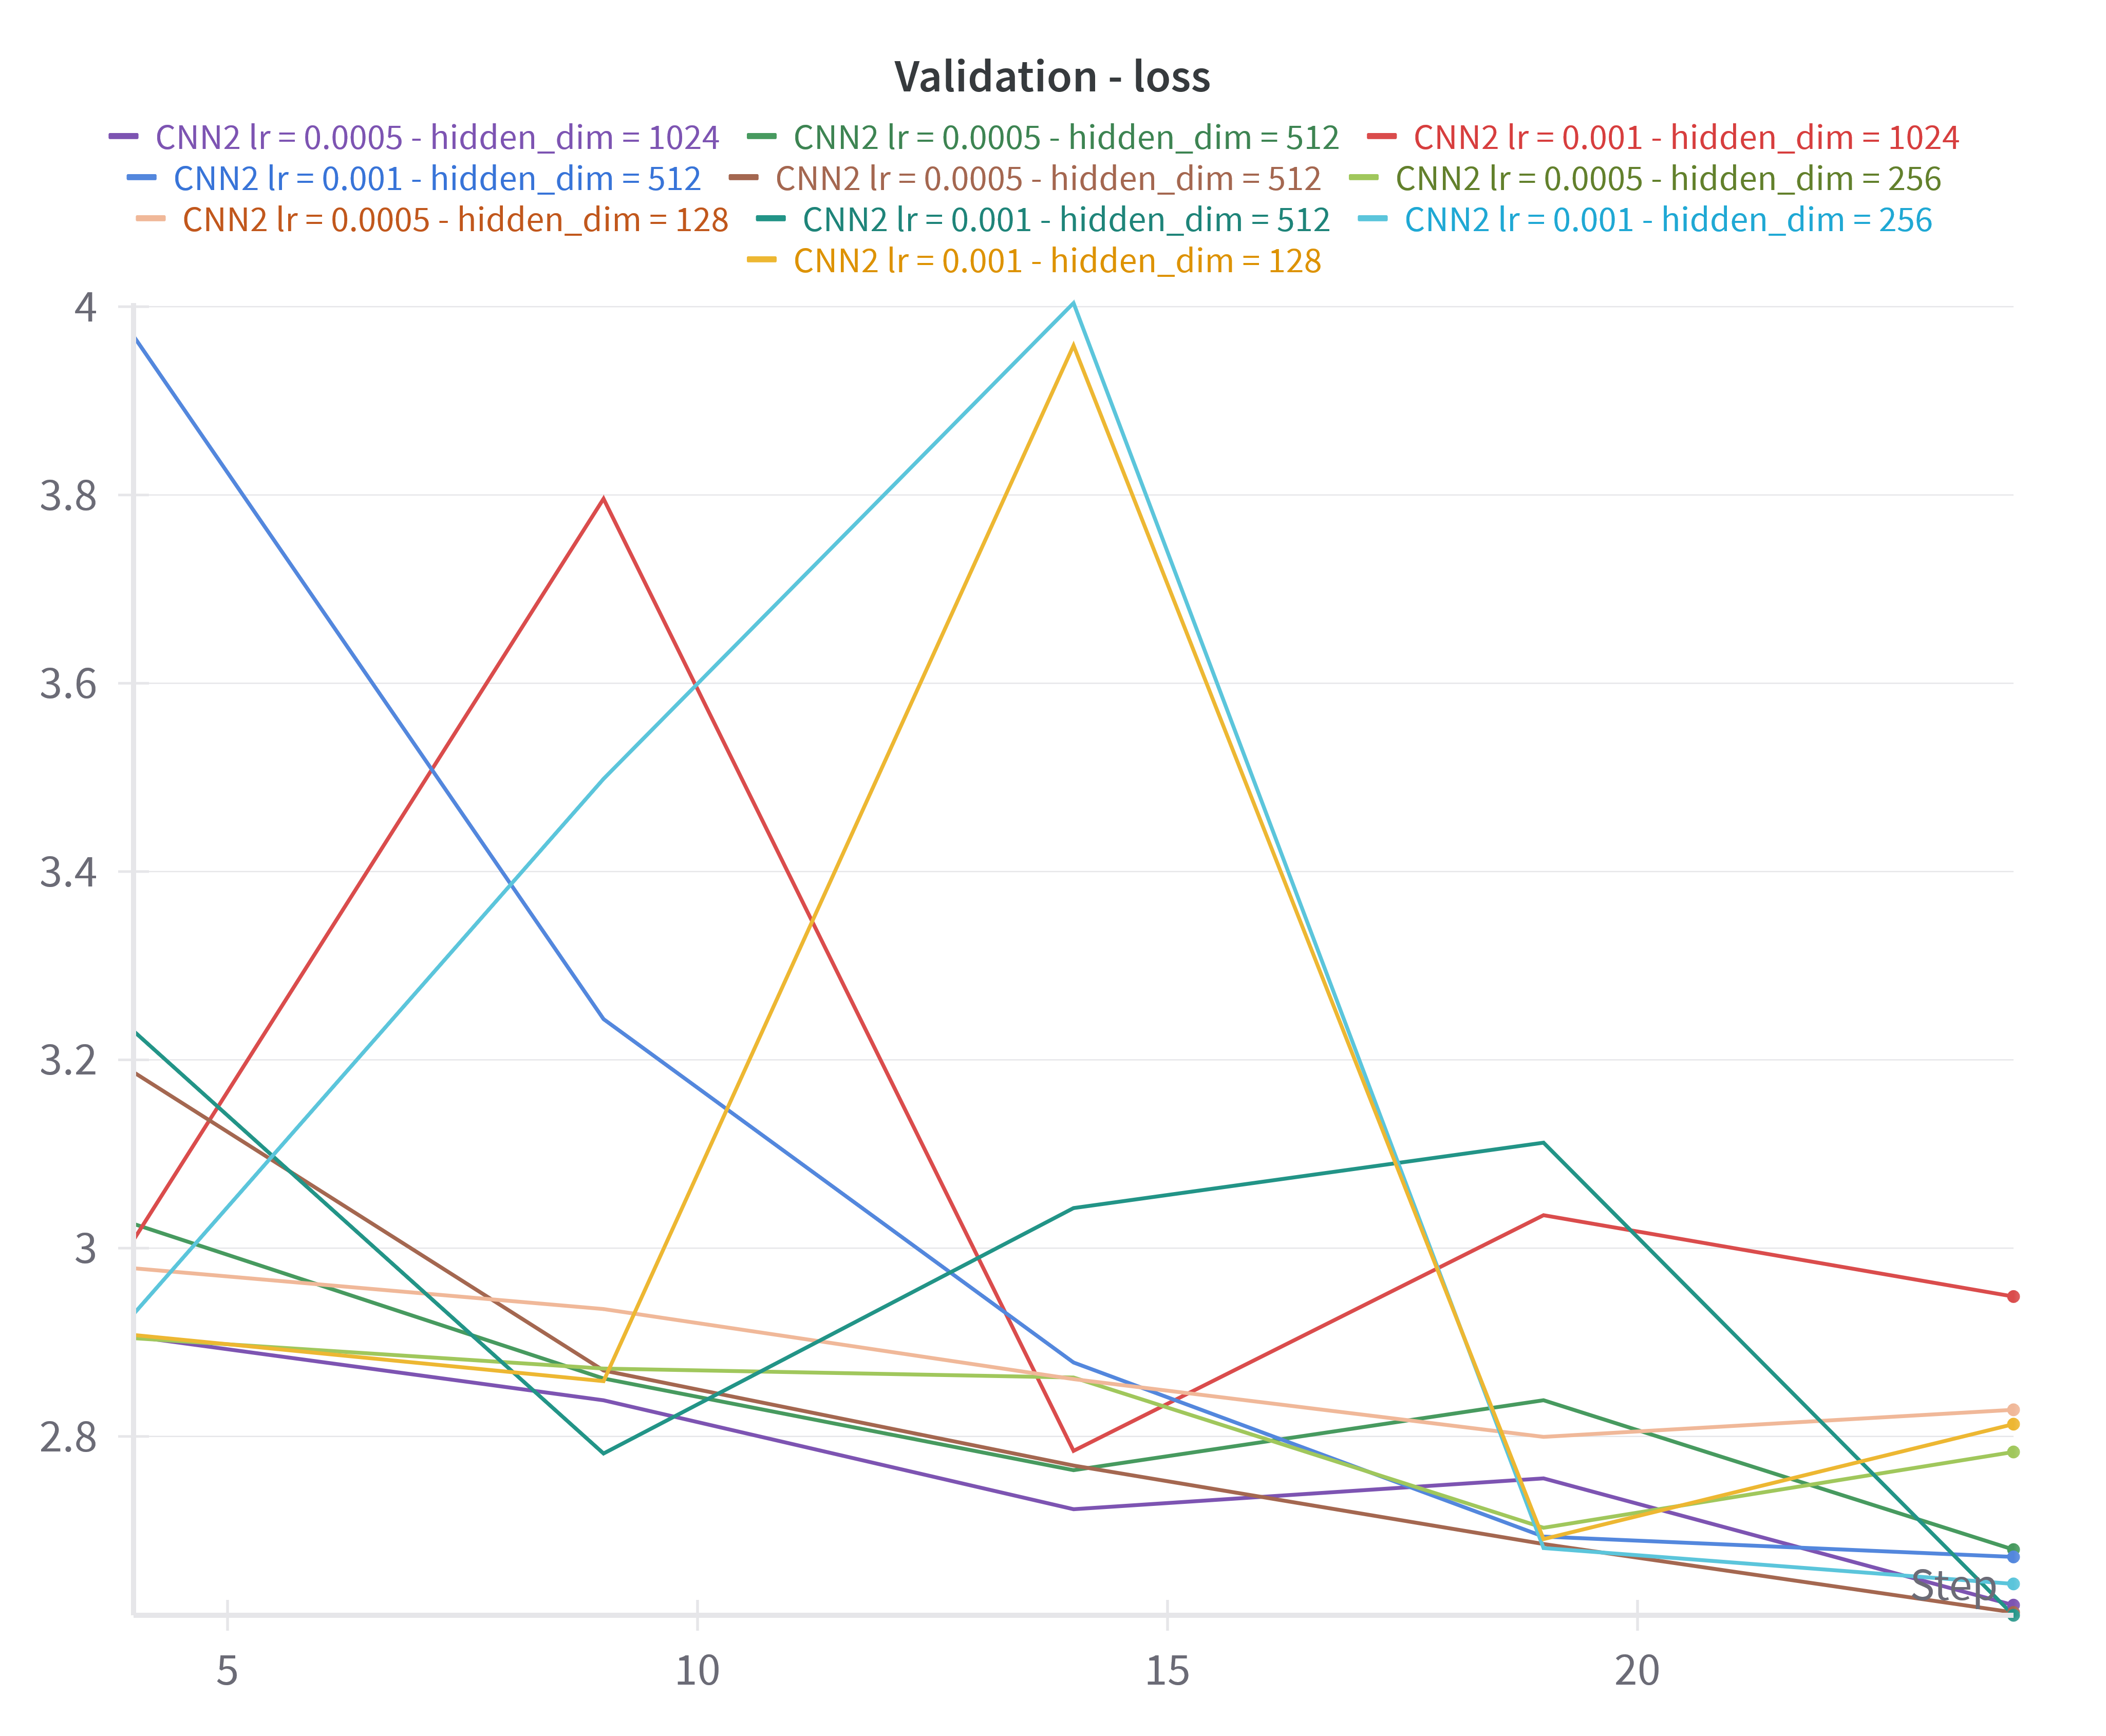

| lr     | dim_hidden | dropout | epochs | Train - loss | Validation - loss |
|--------|------------|---------|--------|--------------|-------------------|
| 0.1    | 512        | 0.1     | 5      | 3.076909497  | 9.964279150       |
| 0.1    | 128        | 0.1     | 5      | 3.130224198  | 3.209313581       |
| 0.1    | 256        | 0.1     | 5      | 3.260309145  | 3.618381676       |
| 0.01   | 128        | 0.1     | 5      | 2.610621318  | 2.742474619       |
| 0.01   | 512        | 0.1     | 5      | 2.653285980  | 2.727823960       |
| 0.01   | 256        | 0.1     | 5      | 2.702020437  | 2.820801747       |
| 0.001  | 256        | 0.1     | 5      | 2.611553162  | 2.643350488       |
| 0.001  | 128        | 0.1     | 5      | 2.636980280  | 2.813038374       |
| 0.001  | 1024       | 0.1     | 5      | 2.642609715  | 2.948589300       |
| 0.001  | 512        | 0.1     | 5      | 2.669770911  | 2.610012368       |
| 0.001  | 512        | 0.1     | 5      | 2.673406407  | 2.672028868       |
| 0.0005 | 512        | 0.1     | 5      | 2.615187570  | 2.679786695       |
| 0.0005 | 1024       | 0.1     | 5      | 2.668986216  | 2.620805816       |
| 0.0005 | 512        | 0.1     | 5      | 2.677843541  | 2.613077691       |
| 0.0005 | 128        | 0.1     | 5      | 2.683014467  | 2.828294741       |
| 0.0005 | 256        | 0.1     | 5      | 2.757484779  | 2.783493594       |


For a batch size of 128 with dropout = 0.01, Lr = 0.001 and dim_hidden = 512 best

#### LR, Hidden dim and batch size

In [ ]:
    config['epochs'] = 5
config['dropout'] = 0.1

batch_sizes = [32, 64, 256, 512]
lr_list = [1e-3,0.0005]
hidden_dims = [512, 1024]

batch_size_ref = 128

for bs in batch_sizes:
    train_loader  = DataLoader(
        train_dataset,
        batch_size=bs,
        shuffle=True,
        num_workers=2
        #collate_fn=lambda batch: generate_batch(batch, config['src_pad_idx'], config['tgt_pad_idx'])
    )

    val_loader  = DataLoader(
        val_dataset,
        batch_size=bs,
        shuffle=False,
        num_workers=2
        #collate_fn=lambda batch: generate_batch(batch, config['src_pad_idx'], config['tgt_pad_idx'])
    )
    for lr in lr_list:
        lr_scaled = lr * (bs / batch_size_ref)
        for hd in hidden_dims:
            run_cfg=copy.deepcopy(config)

            run_cfg['batch_size'] = bs
            run_cfg['lr']         = lr_scaled
            run_cfg['dim_hidden'] = hd
            run_cfg['train_loader'] = train_loader
            run_cfg['val_loader']   = val_loader

            torch.manual_seed(run_cfg['seed'])

            model = CNN2(run_cfg['num_classes'], run_cfg['dim_hidden'], run_cfg['dropout']).to(run_cfg['device'])
            run_cfg['optimizer'] = optim.Adam(model.parameters(), lr=run_cfg['lr'])

            with wandb.init(
                config=run_cfg,
                project='INF8225 - TP4',  # Title of your project
                group=f"CNN2 Grid 2 - dropout = {run_cfg['dropout']} - epochs = {run_cfg['epochs']}",
                name=f"CNN2 - bs = {run_cfg['batch_size']} - lr = {run_cfg['lr']} - hidden_dim = {run_cfg['dim_hidden']}",
                save_code=True,
            ):
                train_model(model, run_cfg)
            del model
            torch.cuda.empty_cache()




Starting training for 5 epochs, using cuda.

Epoch 1
Train -   loss: 2.85
Eval -    loss: 2.89
Epoch 1 Train Prediction - Real age: 2, Predicted: 2, Likelihood: 0.2588
Epoch 1 Val Prediction   - Real age: 50, Predicted: 26, Likelihood: 0.0878

Epoch 2
Train -   loss: 2.76
Eval -    loss: 2.81
Epoch 2 Train Prediction - Real age: 26, Predicted: 26, Likelihood: 0.2342
Epoch 2 Val Prediction   - Real age: 6, Predicted: 26, Likelihood: 0.2757

Epoch 3
Train -   loss: 2.73
Eval -    loss: 2.87
Epoch 3 Train Prediction - Real age: 18, Predicted: 60, Likelihood: 0.0704
Epoch 3 Val Prediction   - Real age: 2, Predicted: 2, Likelihood: 0.0531

Epoch 4
Train -   loss: 2.75
Eval -    loss: 2.68
Epoch 4 Train Prediction - Real age: 30, Predicted: 60, Likelihood: 0.1169
Epoch 4 Val Prediction   - Real age: 2, Predicted: 2, Likelihood: 0.2521

Epoch 5
Train -   loss: 2.76
Eval -    loss: 2.62
Epoch 5 Train Prediction - Real age: 32, Predicted: 36, Likelihood: 0.1157
Epoch 5 Val Prediction   - Real a

Train - loss,▇▆▆▅▅▄▅▅█▄▄▃▃▄▄▃▃▃▃▃▃▂▃▂▄▃▂▂▂▂▂▂▂▂▂▂▁▂▁▃
Validation - loss,█▆▇▂▁
Train - loss,2.7559
Validation - loss,2.62444


Starting training for 5 epochs, using cuda.

Epoch 1
Train -   loss: 2.85
Eval -    loss: 2.87
Epoch 1 Train Prediction - Real age: 30, Predicted: 26, Likelihood: 0.2774
Epoch 1 Val Prediction   - Real age: 42, Predicted: 26, Likelihood: 0.0996

Epoch 2
Train -   loss: 2.78
Eval -    loss: 2.77
Epoch 2 Train Prediction - Real age: 66, Predicted: 2, Likelihood: 0.1075
Epoch 2 Val Prediction   - Real age: 32, Predicted: 26, Likelihood: 0.2373

Epoch 3
Train -   loss: 2.80
Eval -    loss: 2.71
Epoch 3 Train Prediction - Real age: 74, Predicted: 80, Likelihood: 0.0582
Epoch 3 Val Prediction   - Real age: 24, Predicted: 26, Likelihood: 0.1129

Epoch 4
Train -   loss: 2.69
Eval -    loss: 2.79
Epoch 4 Train Prediction - Real age: 20, Predicted: 26, Likelihood: 0.1021
Epoch 4 Val Prediction   - Real age: 26, Predicted: 36, Likelihood: 0.0871

Epoch 5
Train -   loss: 2.62
Eval -    loss: 2.61
Epoch 5 Train Prediction - Real age: 80, Predicted: 30, Likelihood: 0.0963
Epoch 5 Val Prediction   - 

Train - loss,█▆▅▄▄▄▃▄▃▅▃▃▃▃▃▃▂▂▇▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▂▁▁
Validation - loss,█▅▄▆▁
Train - loss,2.61929
Validation - loss,2.61219


Starting training for 5 epochs, using cuda.

Epoch 1
Train -   loss: 2.88
Eval -    loss: 2.91
Epoch 1 Train Prediction - Real age: 2, Predicted: 2, Likelihood: 0.2955
Epoch 1 Val Prediction   - Real age: 50, Predicted: 26, Likelihood: 0.0980

Epoch 2
Train -   loss: 2.82
Eval -    loss: 2.87
Epoch 2 Train Prediction - Real age: 26, Predicted: 26, Likelihood: 0.2179
Epoch 2 Val Prediction   - Real age: 6, Predicted: 26, Likelihood: 0.2411

Epoch 3
Train -   loss: 2.77
Eval -    loss: 2.77
Epoch 3 Train Prediction - Real age: 18, Predicted: 2, Likelihood: 0.1373
Epoch 3 Val Prediction   - Real age: 2, Predicted: 2, Likelihood: 0.1176

Epoch 4
Train -   loss: 2.82
Eval -    loss: 2.74
Epoch 4 Train Prediction - Real age: 30, Predicted: 66, Likelihood: 0.1076
Epoch 4 Val Prediction   - Real age: 2, Predicted: 2, Likelihood: 0.2038

Epoch 5
Train -   loss: 2.79
Eval -    loss: 2.69
Epoch 5 Train Prediction - Real age: 32, Predicted: 26, Likelihood: 0.1055
Epoch 5 Val Prediction   - Real ag

Train - loss,█▇▆▅▅▅▄▅▄▄▆▄▃▄▄▃▃▄▃▃▃▃▃▃▃▄▃▃▃▃▃▃▃▁▃▂▂▃▂▂
Validation - loss,█▇▄▃▁
Train - loss,2.7937
Validation - loss,2.68622


Starting training for 5 epochs, using cuda.

Epoch 1
Train -   loss: 2.89
Eval -    loss: 2.91
Epoch 1 Train Prediction - Real age: 30, Predicted: 26, Likelihood: 0.2393
Epoch 1 Val Prediction   - Real age: 42, Predicted: 26, Likelihood: 0.0967

Epoch 2
Train -   loss: 2.85
Eval -    loss: 2.87
Epoch 2 Train Prediction - Real age: 66, Predicted: 2, Likelihood: 0.5519
Epoch 2 Val Prediction   - Real age: 32, Predicted: 26, Likelihood: 0.2737

Epoch 3
Train -   loss: 2.85
Eval -    loss: 2.78
Epoch 3 Train Prediction - Real age: 74, Predicted: 2, Likelihood: 0.0540
Epoch 3 Val Prediction   - Real age: 24, Predicted: 54, Likelihood: 0.0687

Epoch 4
Train -   loss: 2.75
Eval -    loss: 2.74
Epoch 4 Train Prediction - Real age: 20, Predicted: 26, Likelihood: 0.1055
Epoch 4 Val Prediction   - Real age: 26, Predicted: 26, Likelihood: 0.1320

Epoch 5
Train -   loss: 2.68
Eval -    loss: 2.69
Epoch 5 Train Prediction - Real age: 80, Predicted: 30, Likelihood: 0.0983
Epoch 5 Val Prediction   - R

Train - loss,█▇▄▄▄▄▃▃▃▄▃▃▃▃▃▇▃▂▂▂▃▂▂▂▂▂▂▂▂▂▂▁▂▂▂▁▁▂▂▁
Validation - loss,█▇▄▃▁
Train - loss,2.67824
Validation - loss,2.69374


Starting training for 5 epochs, using cuda.

Epoch 1
Train -   loss: 2.89
Eval -    loss: 2.90
Epoch 1 Train Prediction - Real age: 2, Predicted: 2, Likelihood: 0.2739
Epoch 1 Val Prediction   - Real age: 50, Predicted: 30, Likelihood: 0.0508

Epoch 2
Train -   loss: 2.77
Eval -    loss: 2.74
Epoch 2 Train Prediction - Real age: 26, Predicted: 26, Likelihood: 0.2740
Epoch 2 Val Prediction   - Real age: 6, Predicted: 26, Likelihood: 0.3081

Epoch 3
Train -   loss: 2.71
Eval -    loss: 2.67
Epoch 3 Train Prediction - Real age: 18, Predicted: 2, Likelihood: 0.1647
Epoch 3 Val Prediction   - Real age: 2, Predicted: 2, Likelihood: 0.2061

Epoch 4
Train -   loss: 2.69
Eval -    loss: 2.70
Epoch 4 Train Prediction - Real age: 30, Predicted: 54, Likelihood: 0.1098
Epoch 4 Val Prediction   - Real age: 2, Predicted: 2, Likelihood: 0.3357

Epoch 5
Train -   loss: 2.65
Eval -    loss: 2.60
Epoch 5 Train Prediction - Real age: 32, Predicted: 54, Likelihood: 0.0773
Epoch 5 Val Prediction   - Real ag

Train - loss,█▆▅▅▄▄▄▄▄▄▃▃▃▃▃▃▁▃▃▃▃▂▂▂▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂
Validation - loss,█▄▃▃▁
Train - loss,2.64653
Validation - loss,2.59715


Starting training for 5 epochs, using cuda.

Epoch 1
Train -   loss: 2.90
Eval -    loss: 2.90
Epoch 1 Train Prediction - Real age: 30, Predicted: 26, Likelihood: 0.2464
Epoch 1 Val Prediction   - Real age: 42, Predicted: 26, Likelihood: 0.0693

Epoch 2
Train -   loss: 2.77
Eval -    loss: 3.34
Epoch 2 Train Prediction - Real age: 66, Predicted: 86, Likelihood: 0.1192
Epoch 2 Val Prediction   - Real age: 32, Predicted: 36, Likelihood: 0.0994

Epoch 3
Train -   loss: 2.75
Eval -    loss: 2.72
Epoch 3 Train Prediction - Real age: 74, Predicted: 90, Likelihood: 0.0614
Epoch 3 Val Prediction   - Real age: 24, Predicted: 26, Likelihood: 0.1417

Epoch 4
Train -   loss: 2.71
Eval -    loss: 2.72
Epoch 4 Train Prediction - Real age: 20, Predicted: 18, Likelihood: 0.1113
Epoch 4 Val Prediction   - Real age: 26, Predicted: 26, Likelihood: 0.0972

Epoch 5
Train -   loss: 2.65
Eval -    loss: 2.65
Epoch 5 Train Prediction - Real age: 80, Predicted: 30, Likelihood: 0.1042
Epoch 5 Val Prediction   -

Train - loss,█▆▄▄▄▄▃▃▃▃▃▃▃▃▃▂▆▃▂▂▂▂▂▂▃▁▂▂▂▁▁▂▂▁▁▁▁▁▁▁
Validation - loss,▄█▂▂▁
Train - loss,2.64878
Validation - loss,2.64889


Starting training for 5 epochs, using cuda.

Epoch 1
Train -   loss: 2.93
Eval -    loss: 2.91
Epoch 1 Train Prediction - Real age: 2, Predicted: 2, Likelihood: 0.3516
Epoch 1 Val Prediction   - Real age: 50, Predicted: 2, Likelihood: 0.0717

Epoch 2
Train -   loss: 2.84
Eval -    loss: 2.82
Epoch 2 Train Prediction - Real age: 26, Predicted: 26, Likelihood: 0.2390
Epoch 2 Val Prediction   - Real age: 6, Predicted: 26, Likelihood: 0.2459

Epoch 3
Train -   loss: 2.75
Eval -    loss: 2.77
Epoch 3 Train Prediction - Real age: 18, Predicted: 54, Likelihood: 0.0757
Epoch 3 Val Prediction   - Real age: 2, Predicted: 26, Likelihood: 0.0830

Epoch 4
Train -   loss: 2.73
Eval -    loss: 2.68
Epoch 4 Train Prediction - Real age: 30, Predicted: 60, Likelihood: 0.1107
Epoch 4 Val Prediction   - Real age: 2, Predicted: 2, Likelihood: 0.3360

Epoch 5
Train -   loss: 2.70
Eval -    loss: 2.76
Epoch 5 Train Prediction - Real age: 32, Predicted: 26, Likelihood: 0.1134
Epoch 5 Val Prediction   - Real a

Train - loss,█▇▅▄▄▄▄▄▄▄▃▃▃▃▃▃▁▂▂▂▂▂▂▂▃▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁
Validation - loss,█▅▄▁▄
Train - loss,2.69689
Validation - loss,2.76496


Starting training for 5 epochs, using cuda.

Epoch 1
Train -   loss: 2.93
Eval -    loss: 2.90
Epoch 1 Train Prediction - Real age: 30, Predicted: 26, Likelihood: 0.2314
Epoch 1 Val Prediction   - Real age: 42, Predicted: 26, Likelihood: 0.0962

Epoch 2
Train -   loss: 2.82
Eval -    loss: 2.82
Epoch 2 Train Prediction - Real age: 66, Predicted: 2, Likelihood: 0.2198
Epoch 2 Val Prediction   - Real age: 32, Predicted: 26, Likelihood: 0.2317

Epoch 3
Train -   loss: 2.79
Eval -    loss: 2.84
Epoch 3 Train Prediction - Real age: 74, Predicted: 56, Likelihood: 0.0494
Epoch 3 Val Prediction   - Real age: 24, Predicted: 26, Likelihood: 0.1330

Epoch 4
Train -   loss: 2.76
Eval -    loss: 2.75
Epoch 4 Train Prediction - Real age: 20, Predicted: 24, Likelihood: 0.1233
Epoch 4 Val Prediction   - Real age: 26, Predicted: 26, Likelihood: 0.1317

Epoch 5
Train -   loss: 2.70
Eval -    loss: 2.91
Epoch 5 Train Prediction - Real age: 80, Predicted: 54, Likelihood: 0.0651
Epoch 5 Val Prediction   - 

Train - loss,█▆▅▄▄▄▃▃▃▃▃▃▃▃▃▂▆▃▂▂▂▂▂▂▃▁▂▂▂▁▁▂▃▁▁▁▁▁▁▁
Validation - loss,█▄▅▁█
Train - loss,2.69746
Validation - loss,2.91092


Starting training for 5 epochs, using cuda.

Epoch 1
Train -   loss: 2.94
Eval -    loss: 2.93
Epoch 1 Train Prediction - Real age: 2, Predicted: 2, Likelihood: 0.5088
Epoch 1 Val Prediction   - Real age: 50, Predicted: 2, Likelihood: 0.1446

Epoch 2
Train -   loss: 2.84
Eval -    loss: 4.31
Epoch 2 Train Prediction - Real age: 26, Predicted: 54, Likelihood: 0.1113
Epoch 2 Val Prediction   - Real age: 6, Predicted: 54, Likelihood: 0.1359

Epoch 3
Train -   loss: 2.75
Eval -    loss: 3.10
Epoch 3 Train Prediction - Real age: 18, Predicted: 60, Likelihood: 0.0789
Epoch 3 Val Prediction   - Real age: 2, Predicted: 2, Likelihood: 0.0671

Epoch 4
Train -   loss: 2.73
Eval -    loss: 2.71
Epoch 4 Train Prediction - Real age: 30, Predicted: 54, Likelihood: 0.1109
Epoch 4 Val Prediction   - Real age: 2, Predicted: 2, Likelihood: 0.1366

Epoch 5
Train -   loss: 2.68
Eval -    loss: 2.71
Epoch 5 Train Prediction - Real age: 32, Predicted: 36, Likelihood: 0.0877
Epoch 5 Val Prediction   - Real ag

Train - loss,█▅▄▄▃▃▁▂▂▃▂▁▁▁▁
Validation - loss,▂█▃▁▁
Train - loss,2.68291
Validation - loss,2.71073


Starting training for 5 epochs, using cuda.

Epoch 1
Train -   loss: 2.94
Eval -    loss: 3.03
Epoch 1 Train Prediction - Real age: 30, Predicted: 26, Likelihood: 0.1576
Epoch 1 Val Prediction   - Real age: 42, Predicted: 56, Likelihood: 0.0536

Epoch 2
Train -   loss: 2.84
Eval -    loss: 4.57
Epoch 2 Train Prediction - Real age: 66, Predicted: 66, Likelihood: 0.1383
Epoch 2 Val Prediction   - Real age: 32, Predicted: 66, Likelihood: 0.0914

Epoch 3
Train -   loss: 2.80
Eval -    loss: 7.34
Epoch 3 Train Prediction - Real age: 74, Predicted: 86, Likelihood: 0.1281
Epoch 3 Val Prediction   - Real age: 24, Predicted: 90, Likelihood: 0.2533

Epoch 4
Train -   loss: 2.73
Eval -    loss: 6.10
Epoch 4 Train Prediction - Real age: 20, Predicted: 86, Likelihood: 0.1451
Epoch 4 Val Prediction   - Real age: 26, Predicted: 86, Likelihood: 0.1635

Epoch 5
Train -   loss: 2.69
Eval -    loss: 2.75
Epoch 5 Train Prediction - Real age: 80, Predicted: 60, Likelihood: 0.0692
Epoch 5 Val Prediction   -

Train - loss,█▄▃▂▃▂▃▂▂▃▂▁▂▁▁
Validation - loss,▁▄█▆▁
Train - loss,2.694
Validation - loss,2.74782


Starting training for 5 epochs, using cuda.

Epoch 1
Train -   loss: 2.96
Eval -    loss: 2.94
Epoch 1 Train Prediction - Real age: 2, Predicted: 2, Likelihood: 0.2152
Epoch 1 Val Prediction   - Real age: 50, Predicted: 26, Likelihood: 0.0883

Epoch 2
Train -   loss: 2.85
Eval -    loss: 3.09
Epoch 2 Train Prediction - Real age: 26, Predicted: 26, Likelihood: 0.2209
Epoch 2 Val Prediction   - Real age: 6, Predicted: 26, Likelihood: 0.1893

Epoch 3
Train -   loss: 2.79
Eval -    loss: 3.82
Epoch 3 Train Prediction - Real age: 18, Predicted: 60, Likelihood: 0.1059
Epoch 3 Val Prediction   - Real age: 2, Predicted: 86, Likelihood: 0.0981

Epoch 4
Train -   loss: 2.74
Eval -    loss: 2.73
Epoch 4 Train Prediction - Real age: 30, Predicted: 54, Likelihood: 0.1180
Epoch 4 Val Prediction   - Real age: 2, Predicted: 2, Likelihood: 0.4500

Epoch 5
Train -   loss: 2.70
Eval -    loss: 2.93
Epoch 5 Train Prediction - Real age: 32, Predicted: 54, Likelihood: 0.0952
Epoch 5 Val Prediction   - Real 

Train - loss,█▅▄▄▃▃▂▂▂▂▂▂▁▁▁
Validation - loss,▂▃█▁▂
Train - loss,2.70128
Validation - loss,2.92849


Starting training for 5 epochs, using cuda.

Epoch 1
Train -   loss: 2.95
Eval -    loss: 2.92
Epoch 1 Train Prediction - Real age: 30, Predicted: 26, Likelihood: 0.2380
Epoch 1 Val Prediction   - Real age: 42, Predicted: 26, Likelihood: 0.1121

Epoch 2
Train -   loss: 2.86
Eval -    loss: 3.09
Epoch 2 Train Prediction - Real age: 66, Predicted: 60, Likelihood: 0.0748
Epoch 2 Val Prediction   - Real age: 32, Predicted: 26, Likelihood: 0.0987

Epoch 3
Train -   loss: 2.81
Eval -    loss: 4.13
Epoch 3 Train Prediction - Real age: 74, Predicted: 80, Likelihood: 0.0752
Epoch 3 Val Prediction   - Real age: 24, Predicted: 60, Likelihood: 0.1121

Epoch 4
Train -   loss: 2.74
Eval -    loss: 2.99
Epoch 4 Train Prediction - Real age: 20, Predicted: 26, Likelihood: 0.1137
Epoch 4 Val Prediction   - Real age: 26, Predicted: 54, Likelihood: 0.1014

Epoch 5
Train -   loss: 2.71
Eval -    loss: 2.67
Epoch 5 Train Prediction - Real age: 80, Predicted: 60, Likelihood: 0.0762
Epoch 5 Val Prediction   -

Train - loss,█▅▃▂▃▂▄▂▂▂▂▁▂▁▁
Validation - loss,▂▃█▃▁
Train - loss,2.70599
Validation - loss,2.66609


Starting training for 5 epochs, using cuda.

Epoch 1
Train -   loss: 3.02
Eval -    loss: 2.99
Epoch 1 Train Prediction - Real age: 2, Predicted: 2, Likelihood: 0.3569
Epoch 1 Val Prediction   - Real age: 50, Predicted: 2, Likelihood: 0.1669

Epoch 2
Train -   loss: 2.92
Eval -    loss: 2.98
Epoch 2 Train Prediction - Real age: 26, Predicted: 26, Likelihood: 0.3254
Epoch 2 Val Prediction   - Real age: 6, Predicted: 26, Likelihood: 0.2931

Epoch 3
Train -   loss: 2.84
Eval -    loss: 5.63
Epoch 3 Train Prediction - Real age: 18, Predicted: 90, Likelihood: 0.2136
Epoch 3 Val Prediction   - Real age: 2, Predicted: 90, Likelihood: 0.2181

Epoch 4
Train -   loss: 2.78
Eval -    loss: 2.75
Epoch 4 Train Prediction - Real age: 30, Predicted: 54, Likelihood: 0.1037
Epoch 4 Val Prediction   - Real age: 2, Predicted: 2, Likelihood: 0.2691

Epoch 5
Train -   loss: 2.73
Eval -    loss: 4.19
Epoch 5 Train Prediction - Real age: 32, Predicted: 86, Likelihood: 0.1089
Epoch 5 Val Prediction   - Real a

Train - loss,█▄▄▃▂▂▂▁▁▁
Validation - loss,▂▂█▁▄
Train - loss,2.73472
Validation - loss,4.18731


Starting training for 5 epochs, using cuda.

Epoch 1
Train -   loss: 3.03
Eval -    loss: 2.96
Epoch 1 Train Prediction - Real age: 30, Predicted: 26, Likelihood: 0.2298
Epoch 1 Val Prediction   - Real age: 42, Predicted: 26, Likelihood: 0.1454

Epoch 2
Train -   loss: 2.91
Eval -    loss: 3.02
Epoch 2 Train Prediction - Real age: 66, Predicted: 2, Likelihood: 0.0703
Epoch 2 Val Prediction   - Real age: 32, Predicted: 26, Likelihood: 0.1256

Epoch 3
Train -   loss: 2.83
Eval -    loss: 4.22
Epoch 3 Train Prediction - Real age: 74, Predicted: 62, Likelihood: 0.0707
Epoch 3 Val Prediction   - Real age: 24, Predicted: 74, Likelihood: 0.1003

Epoch 4
Train -   loss: 2.78
Eval -    loss: 3.12
Epoch 4 Train Prediction - Real age: 20, Predicted: 26, Likelihood: 0.1132
Epoch 4 Val Prediction   - Real age: 26, Predicted: 60, Likelihood: 0.1148

Epoch 5
Train -   loss: 2.73
Eval -    loss: 2.86
Epoch 5 Train Prediction - Real age: 80, Predicted: 86, Likelihood: 0.0741
Epoch 5 Val Prediction   - 

Train - loss,█▄▃▃▃▂▁▂▂▁
Validation - loss,▁▂█▂▁
Train - loss,2.7336
Validation - loss,2.86479


Starting training for 5 epochs, using cuda.

Epoch 1
Train -   loss: 3.04
Eval -    loss: 2.99
Epoch 1 Train Prediction - Real age: 2, Predicted: 2, Likelihood: 0.3917
Epoch 1 Val Prediction   - Real age: 50, Predicted: 2, Likelihood: 0.1771

Epoch 2
Train -   loss: 2.92
Eval -    loss: 2.94
Epoch 2 Train Prediction - Real age: 26, Predicted: 26, Likelihood: 0.2590
Epoch 2 Val Prediction   - Real age: 6, Predicted: 26, Likelihood: 0.2373

Epoch 3
Train -   loss: 2.83
Eval -    loss: 4.00
Epoch 3 Train Prediction - Real age: 18, Predicted: 86, Likelihood: 0.1385
Epoch 3 Val Prediction   - Real age: 2, Predicted: 86, Likelihood: 0.1071

Epoch 4
Train -   loss: 2.76
Eval -    loss: 2.90
Epoch 4 Train Prediction - Real age: 30, Predicted: 60, Likelihood: 0.0995
Epoch 4 Val Prediction   - Real age: 2, Predicted: 54, Likelihood: 0.0810

Epoch 5
Train -   loss: 2.71
Eval -    loss: 3.47
Epoch 5 Train Prediction - Real age: 32, Predicted: 54, Likelihood: 0.1063
Epoch 5 Val Prediction   - Real 

Train - loss,█▄▄▃▂▂▂▂▁▁
Validation - loss,▂▁█▁▅
Train - loss,2.70696
Validation - loss,3.46845


Starting training for 5 epochs, using cuda.

Epoch 1
Train -   loss: 3.03
Eval -    loss: 2.98
Epoch 1 Train Prediction - Real age: 30, Predicted: 26, Likelihood: 0.1423
Epoch 1 Val Prediction   - Real age: 42, Predicted: 26, Likelihood: 0.1036

Epoch 2
Train -   loss: 2.91
Eval -    loss: 3.25
Epoch 2 Train Prediction - Real age: 66, Predicted: 86, Likelihood: 0.1121
Epoch 2 Val Prediction   - Real age: 32, Predicted: 26, Likelihood: 0.1064

Epoch 3
Train -   loss: 2.83
Eval -    loss: 3.11
Epoch 3 Train Prediction - Real age: 74, Predicted: 80, Likelihood: 0.0456
Epoch 3 Val Prediction   - Real age: 24, Predicted: 54, Likelihood: 0.0641

Epoch 4
Train -   loss: 2.77
Eval -    loss: 2.92
Epoch 4 Train Prediction - Real age: 20, Predicted: 24, Likelihood: 0.1090
Epoch 4 Val Prediction   - Real age: 26, Predicted: 60, Likelihood: 0.0927

Epoch 5
Train -   loss: 2.73
Eval -    loss: 5.32
Epoch 5 Train Prediction - Real age: 80, Predicted: 62, Likelihood: 0.1024
Epoch 5 Val Prediction   -

Train - loss,█▄▃▃▃▂▁▂▂▁
Validation - loss,▁▂▂▁█
Train - loss,2.7302
Validation - loss,5.32395


In [ ]:
config['epochs'] = 5
config['dropout'] = 0.1

batch_sizes = [32, 64, 256, 512]
lr_list = [1e-3,0.0005]
hidden_dims = [512, 1024]

batch_size_ref = 128

for bs in batch_sizes:
    train_loader  = DataLoader(
        train_dataset,
        batch_size=bs,
        shuffle=True,
        num_workers=2
        #collate_fn=lambda batch: generate_batch(batch, config['src_pad_idx'], config['tgt_pad_idx'])
    )

    val_loader  = DataLoader(
        val_dataset,
        batch_size=bs,
        shuffle=False,
        num_workers=2
        #collate_fn=lambda batch: generate_batch(batch, config['src_pad_idx'], config['tgt_pad_idx'])
    )
    for lr in lr_list:
        lr_scaled = lr * (bs / batch_size_ref)
        for hd in hidden_dims:
            run_cfg=copy.deepcopy(config)

            run_cfg['batch_size'] = bs
            run_cfg['lr']         = lr_scaled
            run_cfg['dim_hidden'] = hd
            run_cfg['train_loader'] = train_loader
            run_cfg['val_loader']   = val_loader

            torch.manual_seed(run_cfg['seed'])

            model = CNN2(run_cfg['num_classes'], run_cfg['dim_hidden'], run_cfg['dropout']).to(run_cfg['device'])
            run_cfg['optimizer'] = optim.Adam(model.parameters(), lr=run_cfg['lr'])

            with wandb.init(
                config=run_cfg,
                project='INF8225 - TP4',  # Title of your project
                group=f"CNN2 Grid 2 - dropout = {run_cfg['dropout']} - epochs = {run_cfg['epochs']}",
                name=f"CNN2 - bs = {run_cfg['batch_size']} - lr = {run_cfg['lr']} - hidden_dim = {run_cfg['dim_hidden']}",
                save_code=True,
            ):
                train_model(model, run_cfg)
            del model
            torch.cuda.empty_cache()


Best model is
bs = 64
lr = 0.0005
hidden_dim = 512

### Final Training

In [ ]:
# Build the model, the dataloaders, optimizer and the loss function
# Log every hyperparameters and arguments into the config dictionnary

config = {
    # General parameters
    'epochs': 50,
    'batch_size': 64,
    'lr': 0.0005,
    'device': 'cuda' if torch.cuda.is_available() else 'cpu',
    'clip': 5,

    # Model parameters
    'dim_hidden': 512, # will be used for nn at the end of cnn
    'dropout': 0.1,
    'model_type': 'CNN2',

    # Others
    'seed': 0,
    'log_every': 50,  # Number of batches between each wandb logs

    'num_classes': 30
}

torch.manual_seed(config['seed'])

config['train_loader'] = DataLoader(
    train_dataset,
    batch_size=config['batch_size'],
    shuffle=True,
    num_workers=8 if os.cpu_count() >=12 else 2
    #collate_fn=lambda batch: generate_batch(batch, config['src_pad_idx'], config['tgt_pad_idx'])
)

config['val_loader'] = DataLoader(
    val_dataset,
    batch_size=config['batch_size'],
    shuffle=False,
    num_workers=4 if os.cpu_count() >=12 else 2
    #collate_fn=lambda batch: generate_batch(batch, config['src_pad_idx'], config['tgt_pad_idx'])
)


model = CNN2(config['num_classes'], config['dim_hidden'],config['dropout'])

config['optimizer'] = optim.Adam(
    model.parameters(),
    lr=config['lr'],
)

config['loss'] = nn.CrossEntropyLoss()

summary(
    model
)

Layer (type:depth-idx)                   Param #
CNN2                                     --
├─Sequential: 1-1                        --
│    └─Conv2d: 2-1                       640
│    └─BatchNorm2d: 2-2                  128
│    └─LeakyReLU: 2-3                    --
│    └─Dropout2d: 2-4                    --
│    └─MaxPool2d: 2-5                    --
│    └─Conv2d: 2-6                       73,856
│    └─BatchNorm2d: 2-7                  256
│    └─LeakyReLU: 2-8                    --
│    └─MaxPool2d: 2-9                    --
│    └─Conv2d: 2-10                      295,168
│    └─BatchNorm2d: 2-11                 512
│    └─LeakyReLU: 2-12                   --
│    └─MaxPool2d: 2-13                   --
│    └─AdaptiveAvgPool2d: 2-14           --
├─Sequential: 1-2                        --
│    └─Linear: 2-15                      131,584
│    └─LeakyReLU: 2-16                   --
│    └─Dropout: 2-17                     --
│    └─Linear: 2-18                      16,416
│    

In [ ]:
# config['epochs'] = 40


# with wandb.init(
#         config=config,
#         project='INF8225 - TP4',  # Title of your project
#         group='CNN2 final- test clipping',
#         save_code=True,
#     ):
#     train_model(model, config)

Starting training for 40 epochs, using cuda.

Epoch 1
{'grad_norm': tensor(2.1472, device='cuda:0')}
Train -   loss: 2.68
Eval -    loss: 2.65
Epoch 1 Train Prediction - Real age: 37–39, Predicted: 25–27, Likelihood: 0.2286
Epoch 1 Val Prediction   - Real age: 1–3, Predicted: 25–27, Likelihood: 0.1485

Epoch 2
{'grad_norm': tensor(3.4096, device='cuda:0')}
Train -   loss: 2.67
Eval -    loss: 2.59
Epoch 2 Train Prediction - Real age: 28–30, Predicted: 25–27, Likelihood: 0.2877
Epoch 2 Val Prediction   - Real age: 58–60, Predicted: 25–27, Likelihood: 0.2327

Epoch 3
{'grad_norm': tensor(3.5168, device='cuda:0')}
Train -   loss: 2.63
Eval -    loss: 2.68
Epoch 3 Train Prediction - Real age: 88–90, Predicted: 88–90, Likelihood: 0.2276
Epoch 3 Val Prediction   - Real age: 37–39, Predicted: 34–36, Likelihood: 0.1232

Epoch 4
{'grad_norm': tensor(2.3553, device='cuda:0')}
Train -   loss: 2.58
Eval -    loss: 2.62
Epoch 4 Train Prediction - Real age: 25–27, Predicted: 25–27, Likelihood: 0.168

Traceback (most recent call last):
  File "<ipython-input-46-893784252fef>", line 10, in <cell line: 0>
    train_model(model, config)
  File "<ipython-input-44-735e58e67038>", line 125, in train_model
    logs[name].append(value.cpu().item())  # Don't forget the '.item' to free the cuda memory
                      ^^^^^^^^^^^
KeyboardInterrupt


Train - loss,▂▇▇██▇▅█▇▄▇▆▅▅▄▅▅▃▄▄▄▅▁▃▃▄▂▃▃▂▃▂▂▂▂▂▂▂▂▁
Validation - loss,▂▂▃▂█▂▃▂▂▃▂▂▂▂▂▃▂▃▁▁▁▁▂▂▁▂▁▃▁▁▁▄▂
grad_norm,▁▃▃▂▂▅▂▁▃▄▄▂▃▄▃▂▃▅▂▁█▃▂▅▁▃▁▄▇▂█▂▂▅
Train - loss,2.43119
Validation - loss,2.61153
grad_norm,5.37162


KeyboardInterrupt: 

In [ ]:
config['epochs'] = 50
file_name = "cnn2_final"

final_path = f"{CHECKPOINT_DIR}/{file_name}.pt"

with wandb.init(
        config=config,
        project='INF8225 - TP4',  # Title of your project
        name=f"CNN2 - Final(fix) - bs=64 - d_ff=512 - lr=0.0005 - max_epochs=50",
        group='CNN2 - small',
        save_code=True,
    ):
    train_model(model, config)

torch.save(model.state_dict(), final_path)
print(f"Checkpoints written to {final_path}")

Starting training for 50 epochs, using cuda.

Epoch 1
{'grad_norm': tensor(0.4832, device='cuda:0')}
Train -   loss: 2.94
Eval -    loss: 2.91
Epoch 1 Train Prediction - Real age: 1–3, Predicted: 1–3, Likelihood: 0.2766
Epoch 1 Val Prediction   - Real age: 55–57, Predicted: 1–3, Likelihood: 0.2344

Epoch 2
{'grad_norm': tensor(1.5804, device='cuda:0')}
Train -   loss: 2.91
Eval -    loss: 2.88
Epoch 2 Train Prediction - Real age: 1–3, Predicted: 1–3, Likelihood: 0.2659
Epoch 2 Val Prediction   - Real age: 22–24, Predicted: 25–27, Likelihood: 0.1724

Epoch 3
{'grad_norm': tensor(1.2827, device='cuda:0')}
Train -   loss: 2.83
Eval -    loss: 2.78
Epoch 3 Train Prediction - Real age: 1–3, Predicted: 25–27, Likelihood: 0.2742
Epoch 3 Val Prediction   - Real age: 34–36, Predicted: 25–27, Likelihood: 0.1563

Epoch 4
{'grad_norm': tensor(2.1918, device='cuda:0')}
Train -   loss: 2.76
Eval -    loss: 2.78
Epoch 4 Train Prediction - Real age: 70–72, Predicted: 58–60, Likelihood: 0.0752
Epoch 4 

Train - loss,█▆▅▅▄▄▄▄▄▄▂▃▃▃▃▂▄▂▃▂▂▂▂▂▂▂▂▂▃▂▂▂▂▂▂▅▁▂▁▁
Validation - loss,▅▄▃▃▃▂▂▂▁▄▁█▂▂
grad_norm,▁▃▂▄▄▅▄▄▃▆█▆▅▆▄
Train - loss,2.58957
Validation - loss,2.6975
grad_norm,2.31568


Checkpoints written to /content/drive/MyDrive/INF8225_TP4_ckpt_f/cnn2_final.pt


## VGG


### Classification

In [ ]:
1# Instanciate the datasets

train_dataset, val_dataset = build_datasets(
  df,
  min_age = 1,
  max_age = 90
)


print(f'\nTraining examples: {len(train_dataset):,}')
print(f'Validation examples: {len(val_dataset):,}')


Training examples: 21,256
Validation examples: 2,362


#### Batch Size = 32, Lr = 1e-3 ---- BEST

In [ ]:
config = {
    'epochs': 2,
    'batch_size': 32,
    'lr': 1e-3,
    'clip': 5,
    'num_classes': 30,
    'log_every': 50,
    'early_stop_patience': 6,
    'seed': 0,
    'device': 'cuda' if torch.cuda.is_available() else 'cpu'
}

torch.manual_seed(config['seed'])

config['train_loader'] = DataLoader(
    train_dataset,
    batch_size=config['batch_size'],
    shuffle=True,
    num_workers=8 if os.cpu_count() >=12 else 2
    #collate_fn=lambda batch: generate_batch(batch, config['src_pad_idx'], config['tgt_pad_idx'])
)

config['val_loader'] = DataLoader(
    val_dataset,
    batch_size=config['batch_size'],
    shuffle=False,
    num_workers=4 if os.cpu_count() >=12 else 2
    #collate_fn=lambda batch: generate_batch(batch, config['src_pad_idx'], config['tgt_pad_idx'])
)

vgg_model = timm.create_model(
        "vgg16_bn.tv_in1k",
        pretrained=True,
        in_chans=1,
        num_classes=config['num_classes']
    ).to(DEVICE)


config['optimizer'] = optim.Adam(vgg_model.parameters(), lr=config['lr'])
config['loss'] = nn.CrossEntropyLoss()

summary(vgg_model)

Layer (type:depth-idx)                   Param #
VGG                                      --
├─Sequential: 1-1                        --
│    └─Conv2d: 2-1                       640
│    └─BatchNorm2d: 2-2                  128
│    └─ReLU: 2-3                         --
│    └─Conv2d: 2-4                       36,928
│    └─BatchNorm2d: 2-5                  128
│    └─ReLU: 2-6                         --
│    └─MaxPool2d: 2-7                    --
│    └─Conv2d: 2-8                       73,856
│    └─BatchNorm2d: 2-9                  256
│    └─ReLU: 2-10                        --
│    └─Conv2d: 2-11                      147,584
│    └─BatchNorm2d: 2-12                 256
│    └─ReLU: 2-13                        --
│    └─MaxPool2d: 2-14                   --
│    └─Conv2d: 2-15                      295,168
│    └─BatchNorm2d: 2-16                 512
│    └─ReLU: 2-17                        --
│    └─Conv2d: 2-18                      590,080
│    └─BatchNorm2d: 2-19                 5

In [ ]:
!wandb online

W&B online. Running your script from this directory will now sync to the cloud.


In [ ]:
# config['epochs'] = 1
# file_name = "vgg16_epoch_1"

# final_path = f"{CHECKPOINT_DIR}/{file_name}.pt"

# with wandb.init(
#         config=config,
#         project='INF8225 - TP4',
#         group=f"VGG16",
#         name=f"VGG16 - Test - epoch=1",
#         save_code=True,
#     ):
#     train_model(vgg_model, config)

# torch.save(vgg_model.state_dict(), final_path)
# print(f"Checkpoints written to {final_path}")

Starting training for 1 epochs, using cuda.

Epoch 1
Train -   loss: 2.85
Eval -    loss: 3.37
Epoch 1 Train Prediction - Real age: 72, Predicted: 86, Likelihood: 0.1101
Epoch 1 Val Prediction   - Real age: 26, Predicted: 26, Likelihood: 0.1014


Train - loss,█▅▄▄▄▄▄▃▄▃▃▃▂▁▂
Validation - loss,▁
Train - loss,2.85253
Validation - loss,3.36915


Checkpoints written to /content/drive/MyDrive/INF8225_TP4_ckpt/vgg16_epoch_1.pt


In [ ]:
config['epochs'] = 50
file_name = "vgg16_epoch_50_max"
final_path = f"{CHECKPOINT_DIR}/{file_name}.pt"


with wandb.init(
        config=config,
        project='INF8225 - TP4',  # Title of your project
        group=f"VGG16",
        name=f"VGG16 - epoch=50 max",
        save_code=True,
    ):
    train_model(vgg_model, config)

torch.save(vgg_model.state_dict(), final_path)
print(f"Checkpoints written to {final_path}")

Starting training for 50 epochs, using cuda.

Epoch 1
Train -   loss: 2.54
Eval -    loss: 2.55
Epoch 1 Train Prediction - Real age: 50, Predicted: 26, Likelihood: 0.1541
Epoch 1 Val Prediction   - Real age: 44, Predicted: 30, Likelihood: 0.2985

Epoch 2
Train -   loss: 2.38
Eval -    loss: 2.41
Epoch 2 Train Prediction - Real age: 32, Predicted: 24, Likelihood: 0.2637
Epoch 2 Val Prediction   - Real age: 2, Predicted: 2, Likelihood: 0.9961

Epoch 3
Train -   loss: 2.28
Eval -    loss: 2.30
Epoch 3 Train Prediction - Real age: 20, Predicted: 26, Likelihood: 0.1800
Epoch 3 Val Prediction   - Real age: 26, Predicted: 26, Likelihood: 0.2592

Epoch 4
Train -   loss: 2.32
Eval -    loss: 2.32
Epoch 4 Train Prediction - Real age: 26, Predicted: 26, Likelihood: 0.1841
Epoch 4 Val Prediction   - Real age: 26, Predicted: 26, Likelihood: 0.2262

Epoch 5
Train -   loss: 2.28
Eval -    loss: 2.24
Epoch 5 Train Prediction - Real age: 2, Predicted: 26, Likelihood: 0.2882
Epoch 5 Val Prediction   - R

Train - loss,█▆▆▆▅▅▅▄▄▄▄▄▄▄▄▄▄▄▃▄▄▃▃▃▁▃▄▃▃▃▃▃▃▂▃▃▂▂▂▂
Validation - loss,█▆▄▅▃▂▄▃▃▂▁▁▁▁▃▂▁▁▁▁▃▂▁
Train - loss,1.84626
Validation - loss,2.09809


Checkpoints written to /content/drive/MyDrive/INF8225_TP4_ckpt/vgg16_epoch_35.pt


Quick test to confirm we are not clipping more than necessary

In [ ]:
# config['epochs'] = 50
# config['clip'] = float('inf') # no clipping

# pp = pprint.PrettyPrinter(indent=4)
# pp.pprint(config)

# with wandb.init(
#         config=config,
#         project='INF8225 - TP4',  # Title of your project
#         group=f"VGG16",
#         name=f"VGG16 - test clipping",
#         save_code=True,
#     ):
#     train_model(vgg_model, config)

{   'batch_size': 32,
    'clip': inf,
    'device': 'cuda',
    'early_stop_patience': 6,
    'epochs': 50,
    'log_every': 50,
    'loss': CrossEntropyLoss(),
    'lr': 0.001,
    'num_classes': 30,
    'optimizer': Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
),
    'seed': 0,
    'train_loader': <torch.utils.data.dataloader.DataLoader object at 0x7eda43419850>,
    'val_loader': <torch.utils.data.dataloader.DataLoader object at 0x7eda4348c110>}


Starting training for 50 epochs, using cuda.

Epoch 1
{'grad_norm': tensor(6.4082, device='cuda:0')}
Train -   loss: 2.54
Eval -    loss: 2.59
Epoch 1 Train Prediction - Real age: 73–75, Predicted: 28–30, Likelihood: 0.2194
Epoch 1 Val Prediction   - Real age: 25–27, Predicted: 28–30, Likelihood: 0.1840

Epoch 2
{'grad_norm': tensor(2.4637, device='cuda:0')}
Train -   loss: 2.43
Eval -    loss: 2.64
Epoch 2 Train Prediction - Real age: 4–6, Predicted: 1–3, Likelihood: 0.7166
Epoch 2 Val Prediction   - Real age: 13–15, Predicted: 4–6, Likelihood: 0.1439

Epoch 3
{'grad_norm': tensor(2.0731, device='cuda:0')}
Train -   loss: 2.28
Eval -    loss: 2.42
Epoch 3 Train Prediction - Real age: 31–33, Predicted: 25–27, Likelihood: 0.2616
Epoch 3 Val Prediction   - Real age: 25–27, Predicted: 25–27, Likelihood: 0.2290

Epoch 4
{'grad_norm': tensor(2.3821, device='cuda:0')}
Train -   loss: 2.26
Eval -    loss: 2.30
Epoch 4 Train Prediction - Real age: 13–15, Predicted: 7–9, Likelihood: 0.3737
Epoc

Train - loss,█▆▄▅▄▃▂▃▃▃▃▃▂▃▂▁▂▂▂▃▂▂▂▂▁▂▂▁▂▂▁▂▂▁▁▁▁▁▁▁
Validation - loss,▇█▆▄▄▄▂▂▂▂▃▂▁▂▂▂▂▁▂▂▁▁▁
grad_norm,█▂▂▂▁▁▂▁▁▁▂▂▁▂▁▂▂▂▂▂▁▂▂▁
Train - loss,1.76921
Validation - loss,2.04165
grad_norm,1.65473


early_stop_patience set to 15

In [ ]:
config['epochs'] = 50

config['early_stop_patience'] = 15

with wandb.init(
        config=config,
        project='INF8225 - TP4',  # Title of your project
        group=f"VGG16",
        name=f"VGG16 - epoch=50 max early stop patience = 15",
        save_code=True,
    ):
    train_model(vgg_model, config)


Starting training for 50 epochs, using cuda.

Epoch 1
Train -   loss: 2.58
Eval -    loss: 2.52
Epoch 1 Train Prediction - Real age: 72, Predicted: 62, Likelihood: 0.0763
Epoch 1 Val Prediction   - Real age: 26, Predicted: 26, Likelihood: 0.2693

Epoch 2
Train -   loss: 2.42
Eval -    loss: 2.39
Epoch 2 Train Prediction - Real age: 50, Predicted: 26, Likelihood: 0.1367
Epoch 2 Val Prediction   - Real age: 44, Predicted: 26, Likelihood: 0.2891

Epoch 3
Train -   loss: 2.43
Eval -    loss: 2.87
Epoch 3 Train Prediction - Real age: 32, Predicted: 8, Likelihood: 0.1199
Epoch 3 Val Prediction   - Real age: 2, Predicted: 2, Likelihood: 0.9998

Epoch 4
Train -   loss: 2.23
Eval -    loss: 2.26
Epoch 4 Train Prediction - Real age: 20, Predicted: 18, Likelihood: 0.2691
Epoch 4 Val Prediction   - Real age: 26, Predicted: 26, Likelihood: 0.2501

Epoch 5
Train -   loss: 2.34
Eval -    loss: 2.36
Epoch 5 Train Prediction - Real age: 26, Predicted: 26, Likelihood: 0.1850
Epoch 5 Val Prediction   - R

Train - loss,█▆▆▅▄▄▄▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▂
Validation - loss,▅▄█▃▄▃▂▂▂▂▂▁▁▁▂▂▁▂▁▁▂▂▁▁▁▂▁▁▂▁▂
Train - loss,1.70564
Validation - loss,2.13209


In [ ]:
from google.colab import output
output.eval_js('new Audio("https://upload.wikimedia.org/wikipedia/commons/0/05/Beep-09.ogg").play()')

#### Batch Size = 128, Lr = 1e-4, LR Scheduler

In [ ]:
gc.collect()
torch.cuda.empty_cache()

In [ ]:
config = {
    'epochs': 50,
    'batch_size': 128,
    'lr': 1e-4,
    'clip': 5,
    'num_classes': 30,
    'log_every': 50,
    'early_stop_patience': 15,
    'seed': 0,
    'device': 'cuda' if torch.cuda.is_available() else 'cpu'
}

torch.manual_seed(config['seed'])
torch.cuda.manual_seed_all(config['seed'])

config['train_loader'] = DataLoader(
    train_dataset,
    batch_size=config['batch_size'],
    shuffle=True,
    num_workers=8 if os.cpu_count() >=12 else 2,
    pin_memory=True
    #collate_fn=lambda batch: generate_batch(batch, config['src_pad_idx'], config['tgt_pad_idx'])
)

config['val_loader'] = DataLoader(
    val_dataset,
    batch_size=config['batch_size'],
    shuffle=False,
    num_workers=4 if os.cpu_count() >=12 else 2,
    pin_memory=True
    #collate_fn=lambda batch: generate_batch(batch, config['src_pad_idx'], config['tgt_pad_idx'])
)

vgg_model = timm.create_model(
        "vgg16_bn.tv_in1k",
        pretrained=True,
        in_chans=1,
        num_classes=config['num_classes']
    ).to(DEVICE)

config['optimizer'] = optim.Adam(vgg_model.parameters(), lr=config['lr'])
config['scheduler'] = torch.optim.lr_scheduler.ReduceLROnPlateau(config['optimizer'], mode='min', factor=0.1, patience=5, verbose=True)
config['loss'] = nn.CrossEntropyLoss()

summary(vgg_model)

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning:

The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.



Layer (type:depth-idx)                   Param #
VGG                                      --
├─Sequential: 1-1                        --
│    └─Conv2d: 2-1                       640
│    └─BatchNorm2d: 2-2                  128
│    └─ReLU: 2-3                         --
│    └─Conv2d: 2-4                       36,928
│    └─BatchNorm2d: 2-5                  128
│    └─ReLU: 2-6                         --
│    └─MaxPool2d: 2-7                    --
│    └─Conv2d: 2-8                       73,856
│    └─BatchNorm2d: 2-9                  256
│    └─ReLU: 2-10                        --
│    └─Conv2d: 2-11                      147,584
│    └─BatchNorm2d: 2-12                 256
│    └─ReLU: 2-13                        --
│    └─MaxPool2d: 2-14                   --
│    └─Conv2d: 2-15                      295,168
│    └─BatchNorm2d: 2-16                 512
│    └─ReLU: 2-17                        --
│    └─Conv2d: 2-18                      590,080
│    └─BatchNorm2d: 2-19                 5

In [ ]:
# file_name = "vgg16_epoch_50_max"
# final_path = f"{CHECKPOINT_DIR}/{file_name}.pt"

pp = pprint.PrettyPrinter(indent=4)
pp.pprint(config)

with wandb.init(
        config=config,
        project='INF8225 - TP4',  # Title of your project
        group=f"VGG16",
        name=f"VGG16 - epoch=50 max - bs=128 - lr=1e-4 - scheduler ",
        save_code=True,
    ):
    train_model(vgg_model, config)

# torch.save(vgg_model.state_dict(), final_path)
# print(f"Checkpoints written to {final_path}")

{   'batch_size': 128,
    'clip': 5,
    'device': 'cuda',
    'early_stop_patience': 15,
    'epochs': 50,
    'log_every': 50,
    'loss': CrossEntropyLoss(),
    'lr': 0.0001,
    'num_classes': 30,
    'optimizer': Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.0001
    maximize: False
    weight_decay: 0
),
    'scheduler': <torch.optim.lr_scheduler.ReduceLROnPlateau object at 0x7eda427db650>,
    'seed': 0,
    'train_loader': <torch.utils.data.dataloader.DataLoader object at 0x7ed8c15d58d0>,
    'val_loader': <torch.utils.data.dataloader.DataLoader object at 0x7ed8c37ca9d0>}


Starting training for 50 epochs, using cuda.

Epoch 1
Train -   loss: 2.11
Eval -    loss: 2.12
Epoch 1 Train Prediction - Real age: 73–75, Predicted: 61–63, Likelihood: 0.0861
Epoch 1 Val Prediction   - Real age: 25–27, Predicted: 25–27, Likelihood: 0.3694

Epoch 2
Train -   loss: 1.94
Eval -    loss: 2.08
Epoch 2 Train Prediction - Real age: 4–6, Predicted: 1–3, Likelihood: 0.5551
Epoch 2 Val Prediction   - Real age: 13–15, Predicted: 13–15, Likelihood: 0.2626

Epoch 3
Train -   loss: 1.95
Eval -    loss: 2.04
Epoch 3 Train Prediction - Real age: 31–33, Predicted: 34–36, Likelihood: 0.2744
Epoch 3 Val Prediction   - Real age: 25–27, Predicted: 49–51, Likelihood: 0.1144

Epoch 4
Train -   loss: 1.89
Eval -    loss: 2.05
Epoch 4 Train Prediction - Real age: 13–15, Predicted: 13–15, Likelihood: 0.2553
Epoch 4 Val Prediction   - Real age: 22–24, Predicted: 28–30, Likelihood: 0.3291

Epoch 5
Train -   loss: 1.76
Eval -    loss: 2.12
Epoch 5 Train Prediction - Real age: 28–30, Predicted: 2

### Regression

In [ ]:
1# Instanciate the datasets

train_dataset_reg, val_dataset_reg = build_datasets(
  df,
  min_age = 1,
  max_age = 90,
  label_mode="regression"
)


print(f'\nTraining examples: {len(train_dataset):,}')
print(f'Validation examples: {len(val_dataset):,}')


Training examples: 21,256
Validation examples: 2,362


#### Batch Size = 32, Lr = 3e-4

##### L1Loss

In [ ]:
reg_cfg = {
    'epochs': 40,
    'batch_size': 32,
    'lr': 3e-4,
    'clip': 5,
    'device': DEVICE,
    'log_every': 50,
    'early_stop_patience': 15,
    'seed': 0,
    'device': 'cuda' if torch.cuda.is_available() else 'cpu'
}

torch.manual_seed(reg_cfg['seed'])

reg_cfg['train_loader'] = DataLoader(
    train_dataset_reg,
    batch_size=reg_cfg['batch_size'],
    shuffle=True,
    pin_memory=True,
    num_workers=8 if os.cpu_count() >=12 else 2
    #collate_fn=lambda batch: generate_batch(batch, config['src_pad_idx'], config['tgt_pad_idx'])
)

reg_cfg['val_loader'] = DataLoader(
    val_dataset_reg,
    batch_size=reg_cfg['batch_size'],
    shuffle=False,
    num_workers=4 if os.cpu_count() >=12 else 2,
    pin_memory=True,
    #collate_fn=lambda batch: generate_batch(batch, config['src_pad_idx'], config['tgt_pad_idx'])
)


vgg_reg = timm.create_model("vgg16_bn.tv_in1k",
                            pretrained=True,
                            in_chans=1,
                            num_classes=1).to(DEVICE)


reg_cfg['optimizer'] = optim.Adam(vgg_reg.parameters(), lr=reg_cfg['lr'])
reg_cfg['loss']      = nn.L1Loss()

summary(vgg_reg)

Layer (type:depth-idx)                   Param #
VGG                                      --
├─Sequential: 1-1                        --
│    └─Conv2d: 2-1                       640
│    └─BatchNorm2d: 2-2                  128
│    └─ReLU: 2-3                         --
│    └─Conv2d: 2-4                       36,928
│    └─BatchNorm2d: 2-5                  128
│    └─ReLU: 2-6                         --
│    └─MaxPool2d: 2-7                    --
│    └─Conv2d: 2-8                       73,856
│    └─BatchNorm2d: 2-9                  256
│    └─ReLU: 2-10                        --
│    └─Conv2d: 2-11                      147,584
│    └─BatchNorm2d: 2-12                 256
│    └─ReLU: 2-13                        --
│    └─MaxPool2d: 2-14                   --
│    └─Conv2d: 2-15                      295,168
│    └─BatchNorm2d: 2-16                 512
│    └─ReLU: 2-17                        --
│    └─Conv2d: 2-18                      590,080
│    └─BatchNorm2d: 2-19                 5

In [ ]:
reg_cfg['epochs'] = 40
file_name = "vgg16_reg_epoch_50_max"
final_path = f"{CHECKPOINT_DIR}/{file_name}.pt"


with wandb.init(
        config=reg_cfg,
        project='INF8225 - TP4',  # Title of your project
        group=f"VGG16 - reg",
        name=f"VGG16 - Regession epoch=50 max",
        save_code=True,
    ):
    train_model(vgg_reg, reg_cfg,classification=False)

torch.save(vgg_reg.state_dict(), final_path)
print(f"Checkpoints written to {final_path}")

Starting training for 40 epochs, using cuda.

Epoch 1
Train -   loss: 6.79
Eval -    loss: 7.03
Epoch 1 Train Prediction - Real age: 36.0, Predicted: 34.9951057434082, Likelihood: 1.0000
Epoch 1 Val Prediction   - Real age: 35.0, Predicted: 42.43038558959961, Likelihood: 1.0000

Epoch 2
Train -   loss: 6.59
Eval -    loss: 6.22
Epoch 2 Train Prediction - Real age: 54.0, Predicted: 51.61906433105469, Likelihood: 1.0000
Epoch 2 Val Prediction   - Real age: 69.0, Predicted: 59.67438507080078, Likelihood: 1.0000

Epoch 3
Train -   loss: 6.19
Eval -    loss: 6.99
Epoch 3 Train Prediction - Real age: 39.0, Predicted: 49.28334426879883, Likelihood: 1.0000
Epoch 3 Val Prediction   - Real age: 35.0, Predicted: 56.761234283447266, Likelihood: 1.0000

Epoch 4
Train -   loss: 6.10
Eval -    loss: 6.20
Epoch 4 Train Prediction - Real age: 54.0, Predicted: 51.0252685546875, Likelihood: 1.0000
Epoch 4 Val Prediction   - Real age: 39.0, Predicted: 44.4954833984375, Likelihood: 1.0000

Epoch 5
Train - 

Train - loss,██▇▅▅▅▄▄▄▄▄▄▃▄▄▃▃▃▃▃▂▃▃▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁
Validation - loss,█▅█▅▄▅▃▄▄▅▃▃▂▂▂▂▃▂▃▁▁▂▁▁▃▂▂▂▂▁▂▁▂▁▁▁▂▂▂▁
Train - loss,3.40587
Validation - loss,4.93296


Checkpoints written to /content/drive/MyDrive/INF8225_TP4_ckpt/vgg16_reg_epoch_50_max.pt


##### SmoothL1Loss ---- BEST

In [ ]:
reg_cfg['epochs'] = 40
reg_cfg['loss'] = nn.SmoothL1Loss(beta=2.0) # 2 year

file_name = "vgg16_reg_epoch_40_max_SmoothL1Loss"
final_path = f"{CHECKPOINT_DIR}/{file_name}.pt"


with wandb.init(
        config=reg_cfg,
        project='INF8225 - TP4',  # Title of your project
        group=f"VGG16 - reg",
        name=f"VGG16 - Regession epoch=40 max - SmoothL1Loss",
        save_code=True,
    ):
    train_model(vgg_reg, reg_cfg,classification=False)

torch.save(vgg_reg.state_dict(), final_path)
print(f"Checkpoints written to {final_path}")

Starting training for 40 epochs, using cuda.

Epoch 1
Train -   loss: 2.92
Eval -    loss: 4.36
Epoch 1 Train Prediction - Real age: 25.0, Predicted: 24.452810287475586, Likelihood: 1.0000
Epoch 1 Val Prediction   - Real age: 32.0, Predicted: 31.17528533935547, Likelihood: 1.0000

Epoch 2
Train -   loss: 2.54
Eval -    loss: 4.06
Epoch 2 Train Prediction - Real age: 72.0, Predicted: 68.419189453125, Likelihood: 1.0000
Epoch 2 Val Prediction   - Real age: 34.0, Predicted: 32.54130554199219, Likelihood: 1.0000

Epoch 3
Train -   loss: 3.26
Eval -    loss: 4.08
Epoch 3 Train Prediction - Real age: 57.0, Predicted: 53.37595748901367, Likelihood: 1.0000
Epoch 3 Val Prediction   - Real age: 31.0, Predicted: 26.498069763183594, Likelihood: 1.0000

Epoch 4
Train -   loss: 2.87
Eval -    loss: 4.12
Epoch 4 Train Prediction - Real age: 32.0, Predicted: 32.43134689331055, Likelihood: 1.0000
Epoch 4 Val Prediction   - Real age: 37.0, Predicted: 25.1695499420166, Likelihood: 1.0000

Epoch 5
Train -

Train - loss,▆▅▆▅▅▆▅▅▅▅▅▅▅▅▅▄▅▄█▅▅▅▅▄▄▄▄▄▁▄▄▄▄▄▃▄▃▃▃▃
Validation - loss,█▂▂▃▇▃▁▃▂▄▄▂▃▃▂▂▁▂▄▃▁
Train - loss,1.92754
Validation - loss,4.01784


Checkpoints written to /content/drive/MyDrive/INF8225_TP4_ckpt/vgg16_reg_epoch_40_max_SmoothL1Loss.pt


In [ ]:
from google.colab import output
output.eval_js('new Audio("https://upload.wikimedia.org/wikipedia/commons/0/05/Beep-09.ogg").play()')

#### Batch Size = 128, Lr = 3e-4, AdamW, LR Scheduler = CosineAnnealingWarmRestarts, SmoothL1Loss

In [ ]:
gc.collect()
torch.cuda.empty_cache()

In [ ]:
reg_cfg = {
    'epochs': 60,
    'batch_size': 192,
    'lr': 3e-4,
    'clip': 5,
    'log_every': 50,
    'early_stop_patience': 12,
    'seed': 0,
    'device': 'cuda' if torch.cuda.is_available() else 'cpu'
}

torch.manual_seed(config['seed'])
torch.cuda.manual_seed_all(config['seed'])

reg_cfg['train_loader'] = DataLoader(
    train_dataset_reg,
    batch_size=reg_cfg['batch_size'],
    shuffle=True,
    pin_memory=True,
    num_workers=8 if os.cpu_count() >=12 else 2
    #collate_fn=lambda batch: generate_batch(batch, config['src_pad_idx'], config['tgt_pad_idx'])
)

reg_cfg['val_loader'] = DataLoader(
    val_dataset_reg,
    batch_size=reg_cfg['batch_size'],
    shuffle=False,
    num_workers=4 if os.cpu_count() >=12 else 2,
    pin_memory=True,
    #collate_fn=lambda batch: generate_batch(batch, config['src_pad_idx'], config['tgt_pad_idx'])
)


vgg_reg = timm.create_model("vgg16_bn.tv_in1k",
                            pretrained=True,
                            in_chans=1,
                            num_classes=1).to(DEVICE)


reg_cfg['optimizer'] = torch.optim.AdamW(
    vgg_reg.parameters(),
    lr=reg_cfg['lr'],
)

reg_cfg['scheduler'] = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
    reg_cfg['optimizer'],
    T_0=10,
    T_mult=2,
    eta_min=1e-6,
    verbose=True
)
reg_cfg['loss'] = nn.SmoothL1Loss(beta=2.0) # 2 year

summary(vgg_reg)

Layer (type:depth-idx)                   Param #
VGG                                      --
├─Sequential: 1-1                        --
│    └─Conv2d: 2-1                       640
│    └─BatchNorm2d: 2-2                  128
│    └─ReLU: 2-3                         --
│    └─Conv2d: 2-4                       36,928
│    └─BatchNorm2d: 2-5                  128
│    └─ReLU: 2-6                         --
│    └─MaxPool2d: 2-7                    --
│    └─Conv2d: 2-8                       73,856
│    └─BatchNorm2d: 2-9                  256
│    └─ReLU: 2-10                        --
│    └─Conv2d: 2-11                      147,584
│    └─BatchNorm2d: 2-12                 256
│    └─ReLU: 2-13                        --
│    └─MaxPool2d: 2-14                   --
│    └─Conv2d: 2-15                      295,168
│    └─BatchNorm2d: 2-16                 512
│    └─ReLU: 2-17                        --
│    └─Conv2d: 2-18                      590,080
│    └─BatchNorm2d: 2-19                 5

In [ ]:
pp = pprint.PrettyPrinter(indent=4)
pp.pprint(reg_cfg)


with wandb.init(
        config=reg_cfg,
        project='INF8225 - TP4',  # Title of your project
        group=f"VGG16 - reg",
        name=f"VGG16 - Regession epoch=40 max - SmoothL1Loss bs=128 - lr=3e-4 - scheduler",
        save_code=True,
    ):
    train_model(vgg_reg, reg_cfg,classification=False)

{   'batch_size': 192,
    'clip': 5,
    'device': 'cuda',
    'early_stop_patience': 12,
    'epochs': 60,
    'log_every': 50,
    'loss': SmoothL1Loss(),
    'lr': 0.0003,
    'optimizer': AdamW (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    initial_lr: 0.0003
    lr: 0.0003
    maximize: False
    weight_decay: 0.01
),
    'scheduler': <torch.optim.lr_scheduler.CosineAnnealingWarmRestarts object at 0x7eda434630d0>,
    'seed': 0,
    'train_loader': <torch.utils.data.dataloader.DataLoader object at 0x7eda4367c3d0>,
    'val_loader': <torch.utils.data.dataloader.DataLoader object at 0x7eda432f3cd0>}


Starting training for 60 epochs, using cuda.

Epoch 1
{'grad_norm': tensor(15.2739, device='cuda:0')}
Train -   loss: 5.64
Eval -    loss: 6.46
Epoch 1 Train Prediction - Real age: 36.0, Predicted: 34.81903839111328, Likelihood: 1.0000
Epoch 1 Val Prediction   - Real age: 35.0, Predicted: 30.365032196044922, Likelihood: 1.0000

Epoch 2
{'grad_norm': tensor(29.5480, device='cuda:0')}
Train -   loss: 4.72
Eval -    loss: 4.66
Epoch 2 Train Prediction - Real age: 54.0, Predicted: 50.931602478027344, Likelihood: 1.0000
Epoch 2 Val Prediction   - Real age: 69.0, Predicted: 67.86385345458984, Likelihood: 1.0000

Epoch 3
{'grad_norm': tensor(12.9132, device='cuda:0')}
Train -   loss: 4.47
Eval -    loss: 4.81
Epoch 3 Train Prediction - Real age: 39.0, Predicted: 47.50072479248047, Likelihood: 1.0000
Epoch 3 Val Prediction   - Real age: 35.0, Predicted: 38.3622932434082, Likelihood: 1.0000

Epoch 4
{'grad_norm': tensor(17.4967, device='cuda:0')}
Train -   loss: 4.09
Eval -    loss: 4.48
Epoch 

Train - loss,███▆█▆▆▆▇▅▄▅▅▅▅▅▄▄▄▄▂▃▃▃▃▃▂▃▄▂▃▂▂▂▂▁▂▁▁▁
Validation - loss,█▃▃▂▂▃▂▂▂▂▂▂▁▂▂▁▂▃▁▁▁▁▃▂
grad_norm,▂▃▁▂▂▂▄▃▅▁▅▂▄▃▃▂▁██▁▅▁▁█▁
Train - loss,2.04081
Validation - loss,4.30201
grad_norm,10.25839


Clip set to 75

In [ ]:
reg_cfg['clip'] = 75

pp = pprint.PrettyPrinter(indent=4)
pp.pprint(reg_cfg)


with wandb.init(
        config=reg_cfg,
        project='INF8225 - TP4',  # Title of your project
        group=f"VGG16 - reg",
        name=f"VGG16 - Regession epoch=40 max - SmoothL1Loss bs=128 - lr=3e-4 - scheduler",
        save_code=True,
    ):
    train_model(vgg_reg, reg_cfg,classification=False)

{   'batch_size': 192,
    'clip': 75,
    'device': 'cuda',
    'early_stop_patience': 12,
    'epochs': 60,
    'log_every': 50,
    'loss': SmoothL1Loss(),
    'lr': 0.0003,
    'optimizer': AdamW (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    initial_lr: 0.0003
    lr: 0.0003
    maximize: False
    weight_decay: 0.01
),
    'scheduler': <torch.optim.lr_scheduler.CosineAnnealingWarmRestarts object at 0x7eda432d5f50>,
    'seed': 0,
    'train_loader': <torch.utils.data.dataloader.DataLoader object at 0x7eda438c7410>,
    'val_loader': <torch.utils.data.dataloader.DataLoader object at 0x7eda436fbed0>}


Starting training for 60 epochs, using cuda.

Epoch 1
{'grad_norm': tensor(15.2739, device='cuda:0')}
Train -   loss: 5.64
Eval -    loss: 6.72
Epoch 1 Train Prediction - Real age: 36.0, Predicted: 27.121166229248047, Likelihood: 1.0000
Epoch 1 Val Prediction   - Real age: 35.0, Predicted: 31.756023406982422, Likelihood: 1.0000

Epoch 2
{'grad_norm': tensor(20.9376, device='cuda:0')}
Train -   loss: 4.70
Eval -    loss: 4.61
Epoch 2 Train Prediction - Real age: 54.0, Predicted: 47.367584228515625, Likelihood: 1.0000
Epoch 2 Val Prediction   - Real age: 69.0, Predicted: 70.46405792236328, Likelihood: 1.0000

Epoch 3
{'grad_norm': tensor(14.9503, device='cuda:0')}
Train -   loss: 4.46
Eval -    loss: 4.93
Epoch 3 Train Prediction - Real age: 39.0, Predicted: 45.56536865234375, Likelihood: 1.0000
Epoch 3 Val Prediction   - Real age: 35.0, Predicted: 36.90070724487305, Likelihood: 1.0000

Epoch 4
{'grad_norm': tensor(17.5828, device='cuda:0')}
Train -   loss: 4.21
Eval -    loss: 4.57
Epoc

Train - loss,█▆▆▅▆▄▅▅▅▄▅▄▄▂▃▃▃▃▂▃▂▃▃▃▃▂▂▂▂▂▂▂▁▂▁▂▁▁▁▁
Validation - loss,█▃▃▂▂▂▂▂▁▃▁▂▂▂▂▁▃▁▂▂▁▂▂▂▁▁▂▁▁▂▁▂
grad_norm,▁▂▁▂▂▂▃▃▅▂▅▂▃▄▂▂▁▇▄▄▅▁▃█▁▁▃▂▁▄▅▂▁
Train - loss,1.72832
Validation - loss,4.31997
grad_norm,13.47222
